In [ ]:
import numpy as np
import torch
import h5py # pour gérer les formats de données utilisés ici
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

In [ ]:
import os
import time
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import sklearn.metrics
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import DataLoader

# TP3: Reconnaissance de signaux de communication par apprentissage profond

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp3.ipynb

Nom des étudiants : Mathis Pernin et Léos Coutrot

2 séances de TP sur ce sujet : le 5 novembre (1h00), le 12 novembre (3h).
Le cours du 19 novembre sera partagé en 3 : cours sur la séparation de sources audio / présentation des mini projets et organisation des soutenances / fin de ce TP.<br>
Deadline pour le rendu du TP: 26 novembre 2025, 13h59, par mail à deepetsignal.mva@gmail.com <br>

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook.
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.

## Problématique

On cherche à identifier un type d'émetteur de communication à partir de l'observation d'un signal provenant de l'émetteur
de 2048 échantillons IQ (In Phase / Quadrature) ie le signal prend des valeurs complexes. On représente la partie
réelle et la partie imaginaire du signal par deux canaux réel d'un signal multivarié.

L'émetteur peut provenir de 6 catégories différentes.
Les paramètres différenciant les différentes catégories sont
- le type de modulation
- la présence ou non de séquences pilotes et le cas échéant la structure de trame pilotes / données
- le débit de la transmission

Les signaux se propagent en champs libre et sont enregistrés par une antenne. Le signal reçu est transposé en bande de base c'est à dire que si le signal est transmis autour d'une fréquence centrale f0, une première étape de traitement du signal à la réception recentre le signal autour de la fréquence 0.


Les différents signaux observés dans ce TP sont entachés de différentes erreurs caractéristiques de la propagation
électromagnétique comme :
- modification aléatoire de la phase du signal lors de la transmission
- imperfection de la transposition en bande de base qui laisse le signal transposé à une fréquence df0 << f0
- présence d'interférence entre les symboles transmis (dûes par exemple à plusieurs chemins de propagation)
- présence d'un bruit blanc additif gaussien

Le niveau du bruit relativement à celui du signal utile est décrit par le SNR (Signal to Noise Ratio) et exprimé en dB. On suppose que le SNR est connu lors de l'acquisition d'un signal. Lors de ce TP nous rencontrerons 4 niveaux de SNR: 30 dB (facile), 20 dB, 10 dB et 0 dB (en espérant qu'on puisse faire quelque chose de ces données).
Un de nos objectifs sera de qualifier la performance des algorithmes mis en place en fonction du SNR.

Les objectifs de ce TP sont:

1. Définir une ou plusieurs architectures de réseaux de neurones profonds et les implémenter en PyTorch
2. Entrainer ces architectures, la fonction de perte employée pourra être la log vraisemblance négative: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html.
3. Qualifier les performances de votre réseau de neurones sur l'ensemble de test via:
   - Le calcul de l'accuracy implémentée par exemple dans le package TorchMetrics (https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
   - La réalisation d'un graphique accuracy vs SNR
   - La réalisation des matrices de confusion entre les différentes classes pour les différents SNR (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
4. Rapporter les performances de vos architectures à leur complexité, la complexité d'un réseau de neurones étant ici résumé au nombre de paramètres libres qu'il fait intervenir

Durant l'entraînement on observera l'évolution de la fonction de perte et de l'accuracy sur l'ensemble d'entraînement et sur l'ensemble de validation.


Les 4 premières parties sont un échauffement sur lequel vous pouvez passer vite si vous êtes à l'aise avec le sujet.
Le gros du travail est dans la partie 5 "Entraînemenent d'un réseau de neurones".

Surtout privilégiez dans un premier temps la simplicité quitte à complexifier votre approche ensuite pour doper ses performances. Ne restez pas bloqué sur des réseaux qui "mettent trop de temps à apprendre"

## Chargement des données en numpy

Le TP est composé de trois jeux de données :
- train.hdf5 destiné à nourrir l'entrainement de réseaux de neurones
- test.hdf5 destiné à évaluer les algorithmes après entrainement
- samples.hdf5 qui est beaucoup plus petit que train.hdf5 et destiné à servir de modèle de données dans une phase de prototypage
des algorithmes et de la pipeline d'entrainement

Les trois jeux de données sont au format hdf5 qui peut être manipulé via l'API Python h5py https://docs.h5py.org/en/stable/quick.html.
Un fichier hdf5 est consitué d'une arborescence de datasets et de groups. Un dataset hdf5 représente un tenseur n dimensionnel. Un dataset se convertit très facilement en numpy array.

Par exemple vous pouvez charger les données samples selon la cellule suivante:

In [ ]:
KAGGLE_PATH = "/kaggle/input/dl-ts-tp3/"
PATH = "/content/drive/MyDrive/MVA/DL_TS/TP3/"

data_path = PATH + 'samples.hdf5'

data = h5py.File(data_path , 'r')

signals = np.array(data['signaux'])
snr =  np.array(data['snr'])
labels_id = np.array(data['labels'])

data.close()

Vous pouvez récupérer le nom de la correspondance entre un label et le nom du standard d'émetteur correspondant via:

In [ ]:
def get_labels(open_h5_file):
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }

def load_dataset(h5_file_path):
    data = h5py.File(h5_file_path , 'r')
    label_mapping = get_labels(data)

    signals = np.array(data['signaux'])
    snr = np.array(data['snr'])
    labels_ids = np.array(data['labels'])

    data.close()

    return signals, snr, labels_ids, label_mapping

In [ ]:
TRAIN_PATH = PATH + "train.hdf5"
VALIDATION_PATH = PATH + "validation.hdf5"
TEST_PATH = PATH + "test.hdf5"

train_signals, train_snr, train_labels, label_mapping = load_dataset(TRAIN_PATH)
eval_signals, eval_snr, eval_labels, _ = load_dataset(VALIDATION_PATH)
test_signals, test_snr, test_labels, _ = load_dataset(TEST_PATH)

### Visualisation des données

Commencez par étudier les données:

    - observez leur taille
    - la distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement
    - visualisez quelques signaux bien choisis selon une ou des représentations que vous choisirez

Remarque : dans ce TP il n'y a pas beaucoup à gagner à faire du feature engineering

In [ ]:
LABEL_MAPPING = label_mapping

In [ ]:
print("Training data :")
print(f'  - Signals shape: {train_signals.shape}')
print(f'  - SNR shape: {train_snr.shape}')
print(f'  - Labels shape: {train_labels.shape}')
print("\n")

print("Validation data :")
print(f'  - Signals shape: {eval_signals.shape}')
print(f'  - SNR shape: {eval_snr.shape}')
print(f'  - Labels shape: {eval_labels.shape}')
print("\n")

print("Test data :")
print(f'  - Signals shape: {test_signals.shape}')
print(f'  - SNR shape: {test_snr.shape}')
print(f'  - Labels shape: {test_labels.shape}')

Training data :
  - Signals shape: (30000, 2048, 2)
  - SNR shape: (30000,)
  - Labels shape: (30000,)


Validation data :
  - Signals shape: (10000, 2048, 2)
  - SNR shape: (10000,)
  - Labels shape: (10000,)


Test data :
  - Signals shape: (10000, 2048, 2)
  - SNR shape: (10000,)
  - Labels shape: (10000,)


Les signaux comportent 2 canaux (1 pour la partie réelle/In Phase et 1 pour la partie imaginaire/Quadrature).

In [ ]:
def plot_class_distribution(labels, label_names, dataset="training"):
    _, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(8,4))
    plt.bar(label_names, counts / len(labels) * 100)
    plt.xlabel('Classes')
    plt.ylabel('% of samples')
    plt.title(f'Distribution of classes in the {dataset} dataset')
    plt.show()

def plot_snr_distribution_by_class(labels, snr, label_mapping, dataset):
    plt.figure(figsize=(6, 3))
    snr_values = [0, 10, 20, 30]
    class_names = []
    snr_counts_per_class = []

    for label_id, label_name in sorted(label_mapping.items()):
        class_names.append(label_name)
        mask = labels == label_id
        snr_class = snr[mask]
        counts_for_class = []
        for snr_val in snr_values:
            count = np.sum(snr_class == snr_val)
            counts_for_class.append(count)
        snr_counts_per_class.append(counts_for_class)

    bottom = np.zeros(len(snr_values))
    for i, (class_name, counts) in enumerate(zip(class_names, snr_counts_per_class)):
        plt.bar(snr_values, counts, bottom=bottom, label=class_name)
        bottom += counts

    plt.xlabel('SNR (dB)')
    plt.ylabel('Number of samples')
    plt.title(f'SNR distribution by class for {dataset} data')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.xticks(snr_values)
    plt.tight_layout()
    plt.show()

def plot_snr_distribution_by_class_subplots(labels, snr, label_mapping, dataset):
    snr_values=[0, 10, 20, 30]

    max_count = max(np.sum(snr[labels == label_id] == snr_val)
                    for label_id in label_mapping.keys()
                    for snr_val in snr_values)

    plt.figure(figsize=(15, 5))
    for i, (label_id, label_name) in enumerate(sorted(label_mapping.items())):
        snr_class = snr[labels == label_id]
        counts = [np.sum(snr_class == snr_val) for snr_val in snr_values]
        plt.subplot(2, 3, i + 1)
        plt.bar(snr_values, counts, alpha=0.7, edgecolor='black')
        plt.xlabel('SNR (dB)')
        plt.ylabel('Number of samples')
        plt.title(f'SNR distribution for {label_name}')
        plt.xticks(snr_values)
        plt.ylim(0, max_count + 2)

    plt.suptitle(f'SNR distribution by class on {dataset} data')
    plt.tight_layout()
    plt.show()

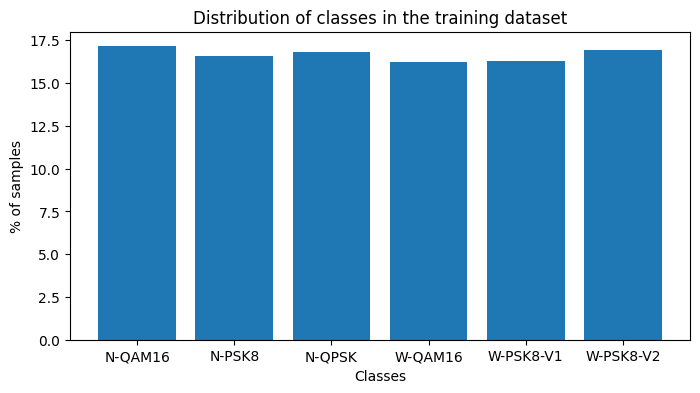

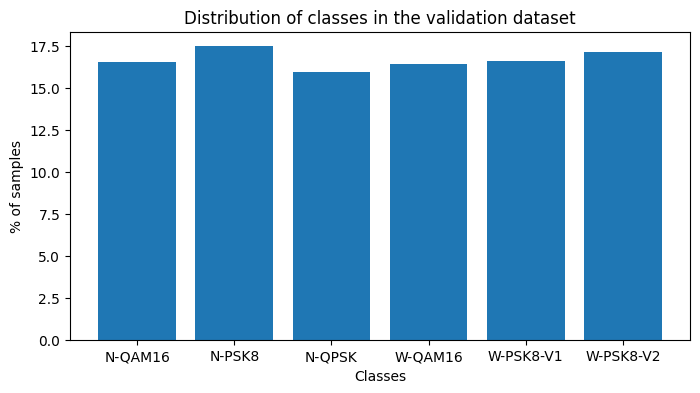

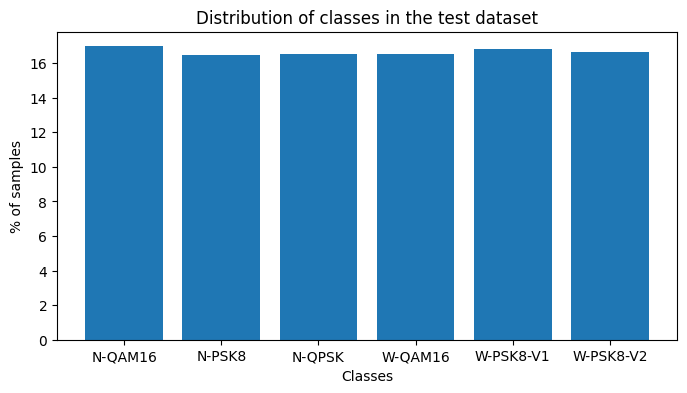

In [ ]:
unique_labels = np.unique(train_labels)
label_names = [LABEL_MAPPING[label_id] for label_id in unique_labels]

plot_class_distribution(train_labels, label_names, dataset="training")
plot_class_distribution(eval_labels, label_names, dataset="validation")
plot_class_distribution(test_labels, label_names, dataset="test")

Les classes sont relativement équilibrées sur chacun des datasets. On peut donc utiliser l'accuracy comme métrique générale pour évaluer notre modèle.

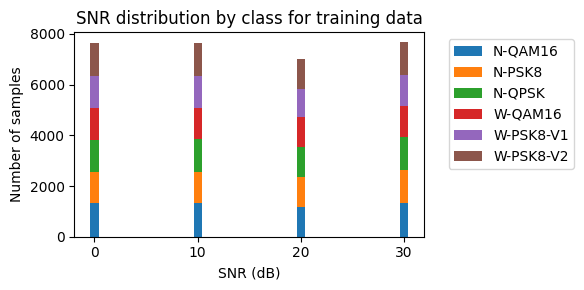

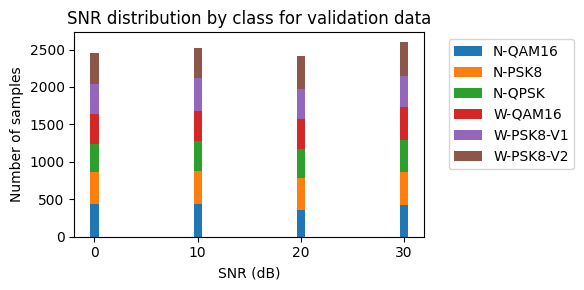

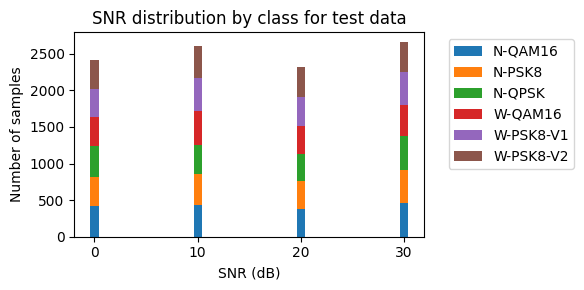

In [ ]:
plot_snr_distribution_by_class(
    labels=train_labels,
    snr=train_snr,
    label_mapping=label_mapping,
    dataset="training"
)

plot_snr_distribution_by_class(
    labels=eval_labels,
    snr=eval_snr,
    label_mapping=label_mapping,
    dataset="validation"
)

plot_snr_distribution_by_class(
    labels=test_labels,
    snr=test_snr,
    label_mapping=label_mapping,
    dataset="test"
)

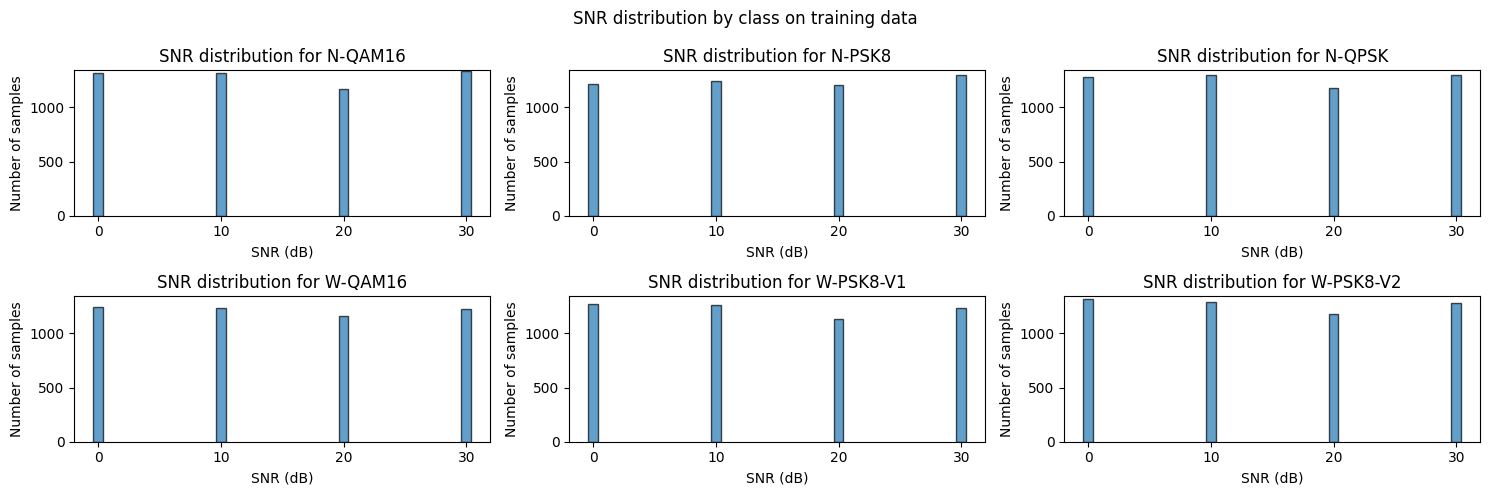

'\nplot_snr_distribution_by_class_subplots(\n    labels=eval_labels,\n    snr=eval_snr,\n    label_mapping=label_mapping,\n    dataset="validation"\n)\n\nplot_snr_distribution_by_class_subplots(\n    labels=test_labels,\n    snr=test_snr,\n    label_mapping=label_mapping,\n    dataset="test"\n)\n'

In [ ]:
plot_snr_distribution_by_class_subplots(
    labels=train_labels,
    snr=train_snr,
    label_mapping=label_mapping,
    dataset="training"
)

"""
plot_snr_distribution_by_class_subplots(
    labels=eval_labels,
    snr=eval_snr,
    label_mapping=label_mapping,
    dataset="validation"
)

plot_snr_distribution_by_class_subplots(
    labels=test_labels,
    snr=test_snr,
    label_mapping=label_mapping,
    dataset="test"
)
"""

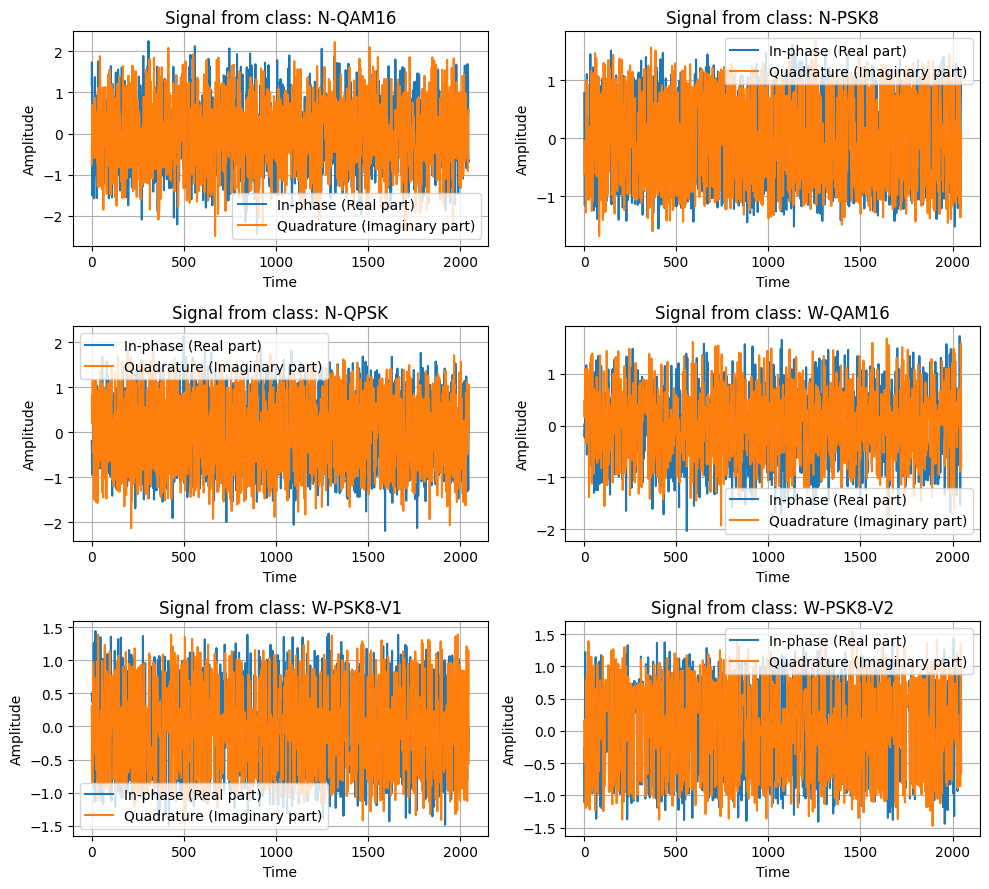

In [ ]:
plt.figure(figsize=(10, 9))
for i, (label_id, label_name) in enumerate(sorted(label_mapping.items())):
    signal = signals[labels_id == label_id][0]
    plt.subplot(3, 2, i + 1)
    plt.plot(signal[:, 0], label='In-phase (Real part)')
    plt.plot(signal[:, 1], label='Quadrature (Imaginary part)')
    plt.legend()
    plt.title(f'Signal from class: {label_name}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid()
plt.tight_layout()
plt.show()

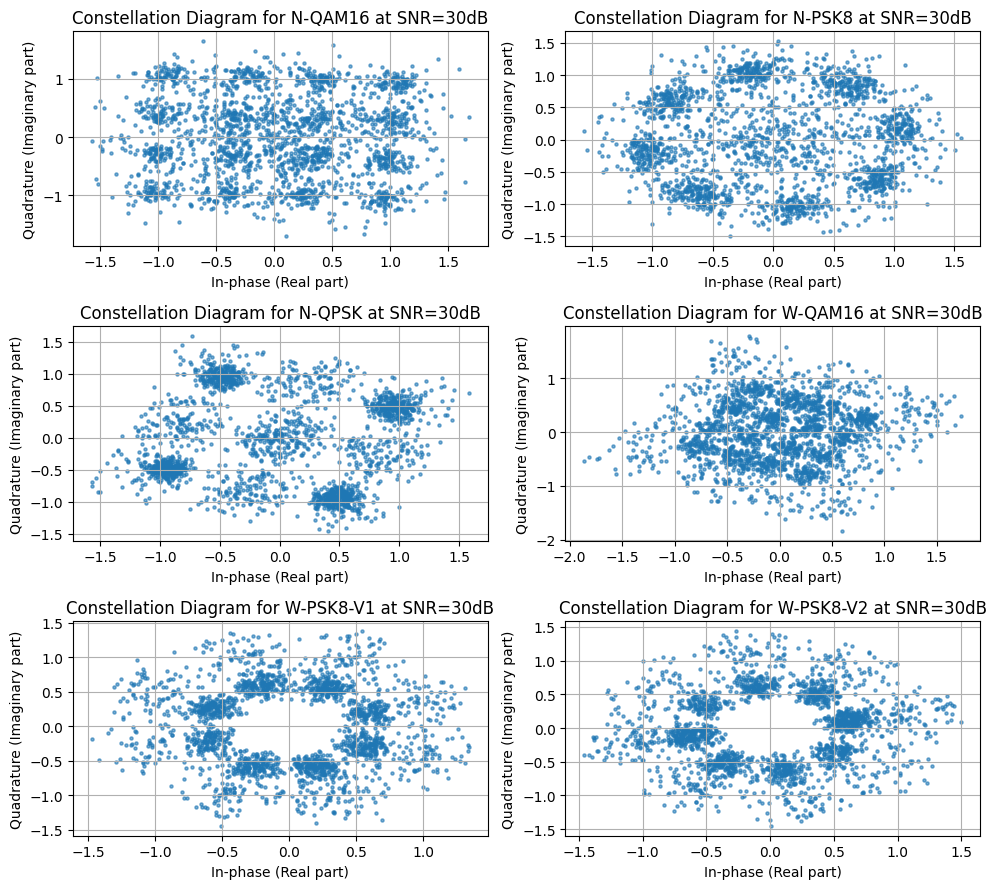

In [ ]:
plt.figure(figsize=(10, 9))
for i, (label_id, label_name) in enumerate(sorted(label_mapping.items())):
    signal = signals[(labels_id == label_id) & (snr == 30)][-1]
    plt.subplot(3, 2, i + 1)
    plt.scatter(signal[:, 0], signal[:, 1], alpha=0.6, s=5)
    plt.title(f'Constellation Diagram for {label_name} at SNR=30dB')
    plt.xlabel('In-phase (Real part)')
    plt.ylabel('Quadrature (Imaginary part)')
    plt.grid()
plt.tight_layout()
plt.show()

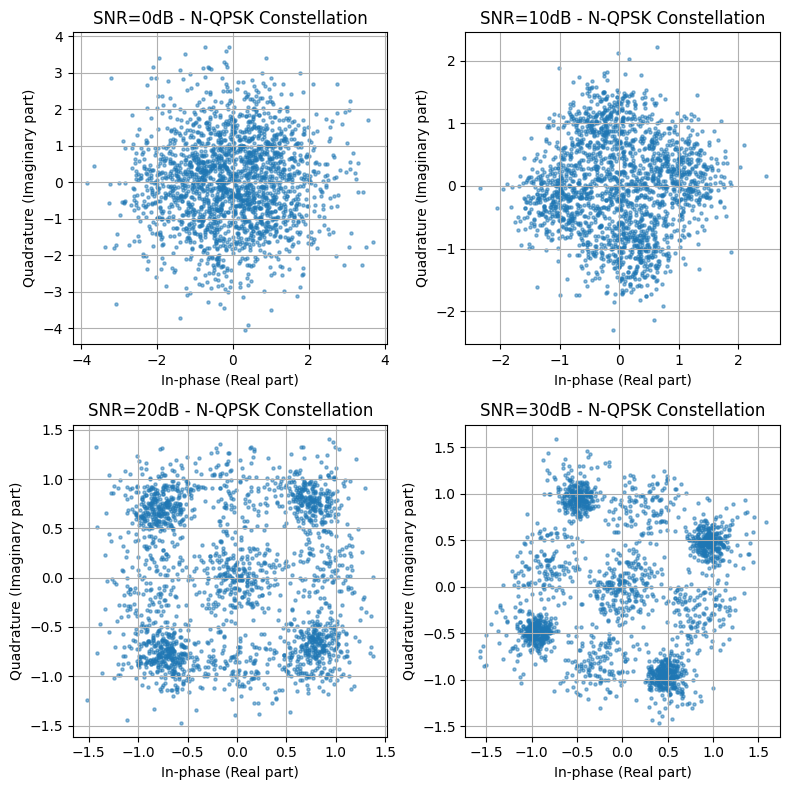

In [ ]:
plt.figure(figsize=(8, 8))
snr_values = [0, 10, 20, 30]
for i, snr_level in enumerate(snr_values):
    signal = signals[(labels_id == 2) & (snr == snr_level)][-1]
    plt.subplot(2, 2, i + 1)
    plt.scatter(signal[:, 0], signal[:, 1], alpha=0.5, s=5)
    plt.title(f'SNR={snr_level}dB - N-QPSK Constellation')
    plt.xlabel('In-phase (Real part)')
    plt.ylabel('Quadrature (Imaginary part)')
    plt.grid()
plt.tight_layout()
plt.show()

## Chargement des données en Pytorch

Pour entrainer des réseaux de neurones profond sur nos données nous allons utiliser le framework Pytorch.
Une première étape va consister à transférer les données de numpy à PyTorch, cela passe par deux objets :
    - un Dataset qui modélise le dataset à haut niveau dans la mémoire de l'ordinateur
    - un Dataloader qui permet d'échantillonner le Dataset Pytorch dans les itérations de l'optimisation du réseau de neurones
    
Un dataset prend la forme
```python
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_data):
        ...
    def __len__(self): #retourne le nombre de données dans le dataset
        ...
    def __getitem__(self,i): #retourne pour chaque indice i un couple (data_i, lablel_i), data_i étant un signal et label_i le label associé au signal
        ...
```

Implémentez une classe Dataset pour le dataset considéré ici

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data):
        with h5py.File(path_to_data, 'r') as data:
          self.signals = np.array(data['signaux'])
          self.snr = np.array(data['snr'])
          self.labels_id = np.array(data['labels'])

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        signals = self.signals[idx]
        snr = self.snr[idx]
        labels_id = self.labels_id[idx]
        return signals, snr, labels_id

Instanciez un objet dataset et testez le sur les données samples
```python
dataset = MyDataset(...)
```

In [ ]:
sample_dataset = MyDataset(data_path)

print(f'Dataset length: {len(sample_dataset)} samples')
print(f'First sample shape: {sample_dataset[0][0].shape}, SNR: {sample_dataset[0][1]}, label ID: {sample_dataset[0][2]}')

Dataset length: 200 samples
First sample shape: (2048, 2), SNR: 10, label ID: 2


Pytorch propose une classe Dataloader qui permet d'échantillonner des batchs de taille fixe à partir d'un dataset.
La cellule suivante donne un exemple d'utilisation

In [ ]:
from torch.utils.data import DataLoader

dataloader = DataLoader(
    sample_dataset,
    batch_size=10,
    shuffle=True
)

Testez le dataloader pour différentes valeurs de batch_size

In [ ]:
batch_sizes = [8, 16, 32]
print("Total dataset size:", len(sample_dataset))

for batch_size in batch_sizes:
    print(f"\n--- Testing with batch_size = {batch_size} ---")
    test_dataloader = DataLoader(
        sample_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    for batch_signals, batch_snr, batch_labels in test_dataloader:
        print(f"  - Batch signals shape: {batch_signals.shape}")
        print(f"  - Batch SNR shape: {batch_snr.shape}")
        print(f"  - Batch labels shape: {batch_labels.shape}")
        break
    num_batches = len(test_dataloader)
    print(f"Total number of batches: {num_batches}")

Total dataset size: 200

--- Testing with batch_size = 8 ---
  - Batch signals shape: torch.Size([8, 2048, 2])
  - Batch SNR shape: torch.Size([8])
  - Batch labels shape: torch.Size([8])
Total number of batches: 25

--- Testing with batch_size = 16 ---
  - Batch signals shape: torch.Size([16, 2048, 2])
  - Batch SNR shape: torch.Size([16])
  - Batch labels shape: torch.Size([16])
Total number of batches: 13

--- Testing with batch_size = 32 ---
  - Batch signals shape: torch.Size([32, 2048, 2])
  - Batch SNR shape: torch.Size([32])
  - Batch labels shape: torch.Size([32])
Total number of batches: 7


## Mise en place d'un réseau "dumb" pour tester la pipeline d'entrainement

Définissez un premier modèle Pytorch qui prend en entrée un batch de données (tenseur de dimensions [B , C, T] avec B la taille du batch, C le nombre de canaux des signaux et T le nombre d'échantillons dans les signaux) et renvoie un batch de vecteur de probabilités (ou de log probabilités si vous préférez) (tenseur de dimensions [B,N] où N est le nombre de classe à identifier).

Ce modèle doit comporter moins de 10000 paramètres libres.

Ce Modèle doit être très simple, il doit être rapide à exécuter, il servira à tester et éventuellement débugger la pipeline d'entrainement que vous mettrez en place un peu plus loin. Un template d'implémentation d'une classe Model se trouve dans les diapositives du cours.

In [ ]:
class DumbModel(nn.Module):
  def __init__(self, input_channels=2, signal_length=2048, num_classes=6):
    super().__init__()

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(input_channels * signal_length, num_classes)

  def forward(self, x):
    x = self.flatten(x)
    x = self.fc1(x)
    return F.log_softmax(x, dim=1)

Instanciez votre modèle et testez la consistence des dimensions de ses entrées et de ses sorties vis à vis des données étudiées. Il s'agit d'un test purement fonctionnel, pas besoin de chercher à réaliser un entraînement à ce point.

In [ ]:
model = DumbModel()
test_batch_size = 16
test_input = torch.randn(test_batch_size, 2048, 2)  # (B, T, C)
test_output = model(test_input)

print(f'Test input shape: {test_input.shape}')
print(f'Test output shape: {test_output.shape}')  # we expect (16, 6)

Test input shape: torch.Size([16, 2048, 2])
Test output shape: torch.Size([16, 6])


Estimez par un calcul "théorique" le nombre de paramètres du modèle que vous avez défini et vérifié que le modèle a bien ce nombre de paramètres en pratique par exemple en utilisant la fonction suivante :

In [ ]:
def count_n_param(model):
    return sum([p.numel() for p in model.parameters()])

In [ ]:
print(f'The model has {count_n_param(model)} trainable parameters.')

The model has 24582 trainable parameters.


## Mise en place de la pipeline d'entraînement

La pipeline d'entrainement consiste à
- charger les données
- les batcher
- réaliser des itération (epochs) de descente de gradient pour optimiser les paramètres d'un algorithme selon une fonction de perte (loss)
- logger l'évolution au fil des epochs  de la loss sur l'ensemble train et l'ensemble de validation et éventuellement de métriques complémentaires

Un cavnevas d'implémentation pourrait être:

```python
device = 'cpu' # set so 'cuda:xx' if you have a GPU, xx is GPU index. L'entraînement des réseaux de neurones est grandement accéléré par l'utilisation d'un GPU

model = ...  # vous instanciez ici votre modèle

loss = .... # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = ... # le nombre d'itérations dans l'entrainement

chemin_vers_sauvegarde_model = # chemin vers un fichier où vous sauvegarderez votre modèle après optimisation pour le réutiliser plus tard.

model.to(device) # on place le modèle dans le GPU si nécessaire

for epoch in range(n_epochs):
    
    for batch_x,batch_y in dataloader_train:
        
        batch_x.to(device)
        batch_y.to(device)
        
        optimizer.zero_grad()
        
        batch_y_predicted = model(batch_x)
        
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
        
        optimizer.step()
        
    for batch_x,batch_y in dataloader_valid:
        
        batch_x.to(device)
        batch_y.to(device)
        
        with torch.no_grad():
            batch_y_predicted = model(batch_x)  
            
        # loggez la loss et les métriques sur le batch de validation

torch.save(model, chemin_vers_sauvegarde_model)

```

Mettez en place votre pipeline et testez là sur votre modèle dumb. Faites en sorte que votre façon de logger les loss et les métriques vous permette de visualiser l'évolution de ces différents indicateurs sur l'ensemble d'entrainement et de validation au fil des epochs.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

@dataclass
class Config:
    epochs: int = 20
    lr: float = 1e-3
    experiment_dir: str = "experiment"
    save_best: bool = True
    verbose: bool = True

class Trainer:
    def __init__(self, model: torch.nn.Module, config: Config):
        self.model = model.to(device)
        self.config = config
        self.fitted = False
        # self.loss_fn = nn.NLLLoss()
        self.loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.config.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=5) #, verbose=True)

        os.makedirs(self.config.experiment_dir, exist_ok=True)
        self._best_val_acc = -1.0
        self.train_losses, self.val_losses = [], []
        self.train_accs, self.val_accs = [], []

    @property
    def best_model_path(self):
        return os.path.join(self.config.experiment_dir, "best_model.pth")

    def train(self, train_loader, valid_loader):
        self.fitted = True
        for epoch in range(1, self.config.epochs + 1):
            start_time = time.time()

            # Training
            self.model.train()
            running_loss, running_correct, running_total = 0.0, 0, 0

            for batch_x, _, batch_y in tqdm(train_loader, desc=f"Epoch {epoch}/{self.config.epochs} - Train", leave=False):
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device).long()

                self.optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = self.loss_fn(outputs, batch_y)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item() * batch_x.size(0)
                _, preds = outputs.max(1)
                running_correct += (preds == batch_y).sum().item()
                running_total += batch_x.size(0)

            train_loss = running_loss / running_total
            train_acc = 100.0 * running_correct / running_total
            self.train_losses.append(train_loss)
            self.train_accs.append(train_acc)

            # Validation
            self.model.eval()
            val_loss_total, val_correct, val_total = 0.0, 0, 0

            with torch.no_grad():
                for batch_x, _, batch_y in tqdm(valid_loader, desc=f"Epoch {epoch}/{self.config.epochs} - Valid", leave=False):
                    batch_x = batch_x.to(device)
                    batch_y = batch_y.to(device).long()

                    outputs = self.model(batch_x)
                    loss = self.loss_fn(outputs, batch_y)

                    val_loss_total += loss.item() * batch_x.size(0)
                    _, preds = outputs.max(1)
                    val_correct += (preds == batch_y).sum().item()
                    val_total += batch_x.size(0)

            val_loss = val_loss_total / val_total
            val_acc = 100.0 * val_correct / val_total
            self.val_losses.append(val_loss)
            self.scheduler.step(val_loss)
            self.val_accs.append(val_acc)

            # Save best model
            if val_acc > self._best_val_acc:
                self._best_val_acc = val_acc
                torch.save(self.model.state_dict(), self.best_model_path)
                saved_msg = "(best model saved)"
            else:
                saved_msg = ""

            # Print epoch summary
            elapsed = time.time() - start_time
            print(f"Epoch {epoch}/{self.config.epochs} | "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% | "
                  f"Time: {elapsed:.1f}s {saved_msg}")
            print("-" * 100)

    def load_best_model(self):
        if os.path.exists(self.best_model_path):
            self.model.load_state_dict(torch.load(self.best_model_path, map_location=device))

    def count_n_param(self):
        print(sum(p.numel() for p in self.model.parameters()))

    def test(self, dataloader, label_mapping=LABEL_MAPPING):

        self.load_best_model()
        self.model.eval()

        total_loss = 0.0
        correct = 0
        total = 0
        all_labels, all_preds = [], []
        snr_bins = {}

        with torch.no_grad():
            bar = tqdm(dataloader, desc="Testing", leave=False)
            for batch_x, batch_snr, batch_y in bar:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device).long()

                outputs = self.model(batch_x)
                loss = self.loss_fn(outputs, batch_y)

                total_loss += loss.item() * batch_x.size(0)
                _, preds = outputs.max(1)
                correct += (preds == batch_y).sum().item()
                total += batch_x.size(0)

                all_labels.extend(batch_y.cpu().numpy().tolist())
                all_preds.extend(preds.cpu().numpy().tolist())

                for s, lab, pr in zip(batch_snr.numpy().tolist(), batch_y.cpu().numpy().tolist(), preds.cpu().numpy().tolist()):
                    snr_bins.setdefault(s, {"labels": [], "preds": []})
                    snr_bins[s]["labels"].append(lab)
                    snr_bins[s]["preds"].append(pr)

                bar.set_postfix({
                    "loss": f"{total_loss / total:.4f}",
                    "acc": f"{100.0 * correct / total:.2f}%"
                })

        avg_loss = total_loss / total
        accuracy = 100.0 * correct / total

        print(f"Test set: avg_loss: {avg_loss:.4f}, acc: {accuracy:.2f}%")
        print(sklearn.metrics.classification_report(all_labels, all_preds))

        # Confusion matrix
        cm = sklearn.metrics.confusion_matrix(all_labels, all_preds)
        disp_labels = [label_mapping[k] for k in sorted(label_mapping.keys())]

        # plt.figure(figsize=(10, 6))
        # sklearn.metrics.ConfusionMatrixDisplay(cm, display_labels=disp_labels).plot()
        # plt.title("Confusion Matrix (Overall)")
        # plt.show()
        plt.figure(figsize=(10, 6))
        disp = sklearn.metrics.ConfusionMatrixDisplay(cm, display_labels=disp_labels)
        disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
        plt.title("Confusion Matrix (Overall)")
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.grid(False)
        plt.tight_layout()
        plt.show()

        # Confusion Matrices
        snr_values = sorted(snr_bins.keys())
        snr_accuracies = []

        for snr in snr_values:
            labs = np.array(snr_bins[snr]["labels"])
            preds = np.array(snr_bins[snr]["preds"])
            acc = (labs == preds).mean() * 100
            snr_accuracies.append(acc)

            cm_s = sklearn.metrics.confusion_matrix(labs, preds, labels=sorted(label_mapping.keys()))
            plt.figure(figsize=(8, 4))
            disp = sklearn.metrics.ConfusionMatrixDisplay(cm_s, display_labels=disp_labels)
            disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
            plt.title(f"Confusion Matrix — SNR={snr} (acc={acc:.2f}%)")

            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.grid(False)
            plt.tight_layout()
            plt.show()

        # Accuracy vs SNR
        plt.figure(figsize=(8, 5))
        plt.plot(snr_values, snr_accuracies, marker="o", linestyle="-")
        plt.xlabel("SNR")
        plt.ylabel("Accuracy (%)")
        plt.title("Accuracy vs SNR")
        plt.grid(True)
        plt.show()

    def plot_training_curves(self, figsize=(10, 5)):
        """Simple, clean training curves for loss and accuracy."""
        if not self.fitted:
            raise RuntimeError("Train the model first (self.fitted is False).")

        epochs = np.arange(1, len(self.train_losses) + 1)

        # Loss plot
        plt.figure(figsize=figsize)
        plt.plot(epochs, self.train_losses, marker="o", label="Train Loss")
        plt.plot(epochs, self.val_losses, marker="s", label="Val Loss")
        plt.title("Training vs Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Accuracy plot
        plt.figure(figsize=figsize)
        plt.plot(epochs, self.train_accs, marker="^", label="Train Acc")
        plt.plot(epochs, self.val_accs, marker="v", label="Val Acc")
        plt.title("Training vs Validation Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

Vérifiez que vous avez bien enregistré votre modèle en fin d'entrainement. Chargez le avec la fonction
```python
modele = torch.load(...)
```
et vérifiez que vous pouvez l'utiliser sur des données du problème.

## Entraînement de réseaux de neurones

Dans cette partie vous définissez une ou si vous avancez suffisamment vite plusieurs architecture de réseaux de neurones profonds et vous les réglez sur les données d'entrainement.
Vous pouvez notamment utiliser des réseaux à base de convolutions et/ou de couches réurrentes. Vous pouvez vous inspirer de ce qui a été dit en cours sur la reconnaissance vocale.

Dans un deuxième temps, si vous le souhaitez vous pouvez tenter de mettre en place des stratégies autour de l'utilisation des données d'entraînement pour améliorer vos résultats. Si vous cherchez à mettre en place de l'augmentation de données vous pouvez vous renseigner sur l'argument collate_fn du dataloader standard de Pytorch.

In [ ]:
train_dataset = MyDataset(TRAIN_PATH)
valid_dataset = MyDataset(VALIDATION_PATH)
test_dataset = MyDataset(TEST_PATH)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = DumbModel().to(device)
config = Config(epochs=15, experiment_dir="simple_model")
trainer = Trainer(model, config)

Epoch 1/15 | Train Loss: 2.1075, Train Acc: 17.28% | Val Loss: 2.1536, Val Acc: 17.71% | Time: 2.2s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 2/15 | Train Loss: 1.9815, Train Acc: 24.52% | Val Loss: 2.2544, Val Acc: 17.22% | Time: 2.2s 
----------------------------------------------------------------------------------------------------


Epoch 3/15 | Train Loss: 1.9588, Train Acc: 26.55% | Val Loss: 2.3258, Val Acc: 17.65% | Time: 2.2s 
----------------------------------------------------------------------------------------------------


Epoch 4/15 | Train Loss: 1.9494, Train Acc: 27.51% | Val Loss: 2.3946, Val Acc: 17.27% | Time: 2.2s 
----------------------------------------------------------------------------------------------------


Epoch 5/15 | Train Loss: 1.9506, Train Acc: 27.90% | Val Loss: 2.4328, Val Acc: 16.90% | Time: 2.2s 
----------------------------------------------------------------------------------------------------


Epoch 6/15 | Train Loss: 1.9501, Train Acc: 28.25% | Val Loss: 2.4534, Val Acc: 17.34% | Time: 2.2s 
----------------------------------------------------------------------------------------------------


Epoch 7/15 | Train Loss: 1.9430, Train Acc: 28.61% | Val Loss: 2.4886, Val Acc: 17.24% | Time: 2.2s 
----------------------------------------------------------------------------------------------------


Epoch 8/15 | Train Loss: 1.7541, Train Acc: 34.43% | Val Loss: 2.3910, Val Acc: 17.40% | Time: 2.2s 
----------------------------------------------------------------------------------------------------


Epoch 9/15 | Train Loss: 1.7135, Train Acc: 34.71% | Val Loss: 2.3799, Val Acc: 17.23% | Time: 2.2s 
----------------------------------------------------------------------------------------------------


Epoch 10/15 | Train Loss: 1.7149, Train Acc: 34.61% | Val Loss: 2.3829, Val Acc: 17.61% | Time: 2.2s 
----------------------------------------------------------------------------------------------------


Epoch 11/15 | Train Loss: 1.7149, Train Acc: 34.47% | Val Loss: 2.3897, Val Acc: 17.31% | Time: 2.2s 
----------------------------------------------------------------------------------------------------


Epoch 12/15 | Train Loss: 1.7158, Train Acc: 34.37% | Val Loss: 2.3847, Val Acc: 17.20% | Time: 2.2s 
----------------------------------------------------------------------------------------------------


Epoch 13/15 | Train Loss: 1.7143, Train Acc: 34.48% | Val Loss: 2.3855, Val Acc: 17.45% | Time: 2.2s 
----------------------------------------------------------------------------------------------------


Epoch 14/15 | Train Loss: 1.6139, Train Acc: 38.61% | Val Loss: 2.3648, Val Acc: 17.36% | Time: 2.2s 
----------------------------------------------------------------------------------------------------


Epoch 15/15 | Train Loss: 1.6028, Train Acc: 39.42% | Val Loss: 2.3631, Val Acc: 17.29% | Time: 2.2s 
----------------------------------------------------------------------------------------------------


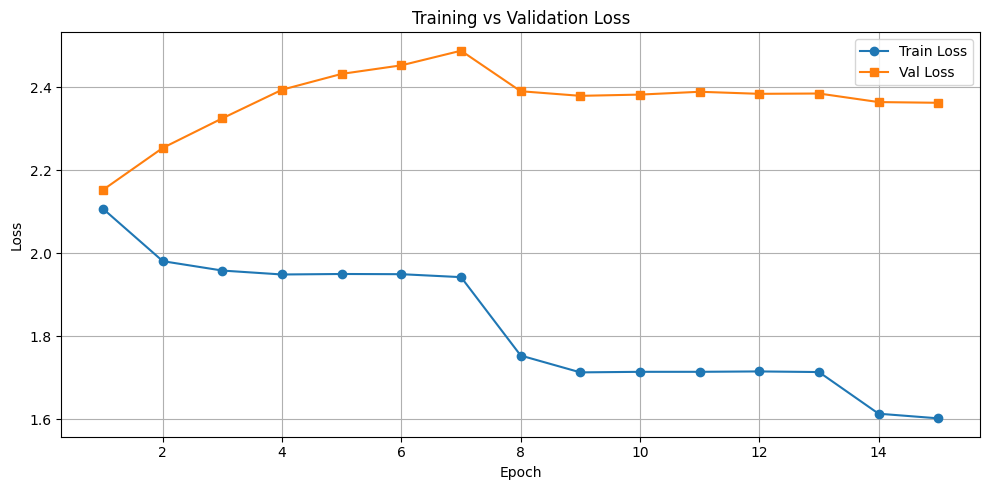

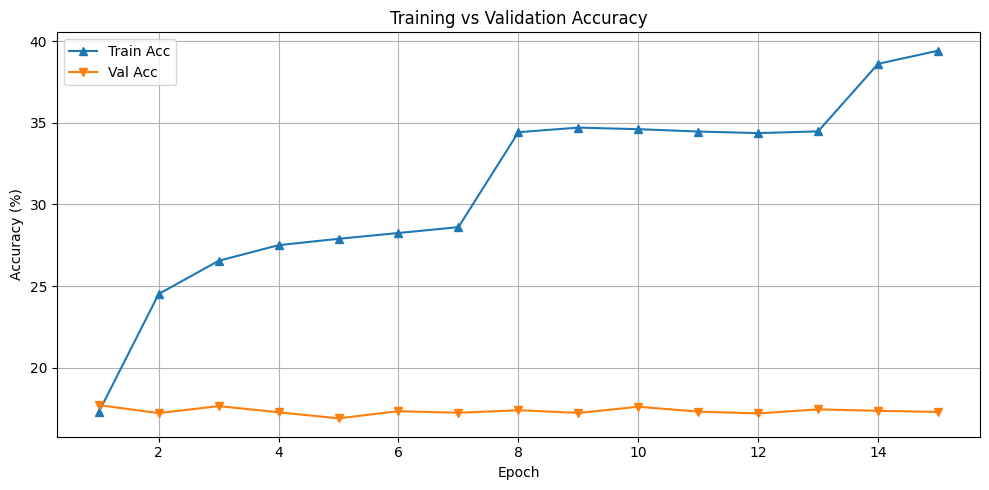

Test set: avg_loss: 2.1734, acc: 16.43%
              precision    recall  f1-score   support

           0       0.17      0.18      0.17      1697
           1       0.16      0.16      0.16      1650
           2       0.16      0.16      0.16      1653
           3       0.16      0.16      0.16      1653
           4       0.18      0.17      0.18      1684
           5       0.16      0.16      0.16      1663

    accuracy                           0.16     10000
   macro avg       0.16      0.16      0.16     10000
weighted avg       0.16      0.16      0.16     10000



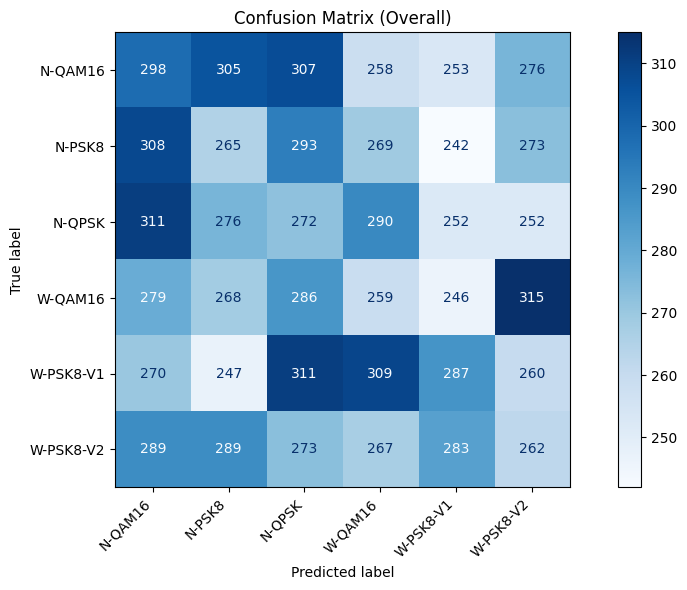

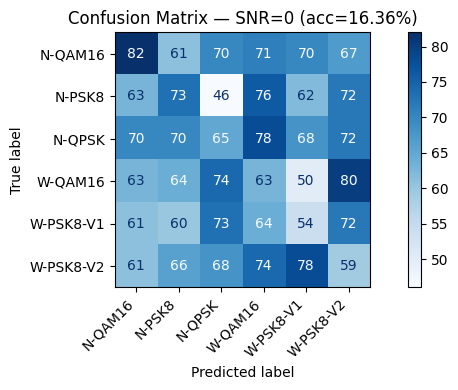

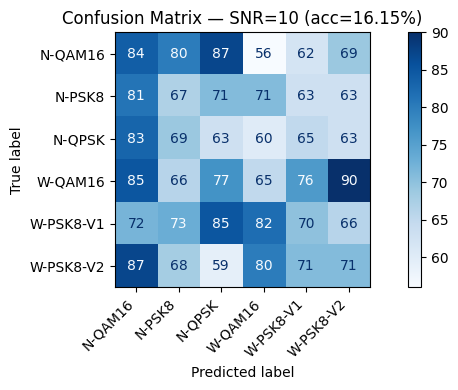

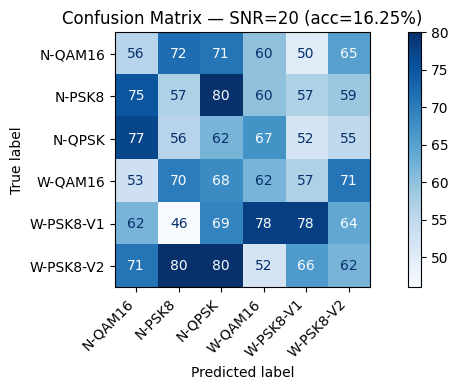

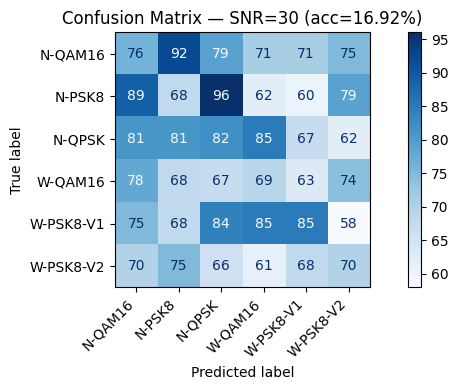

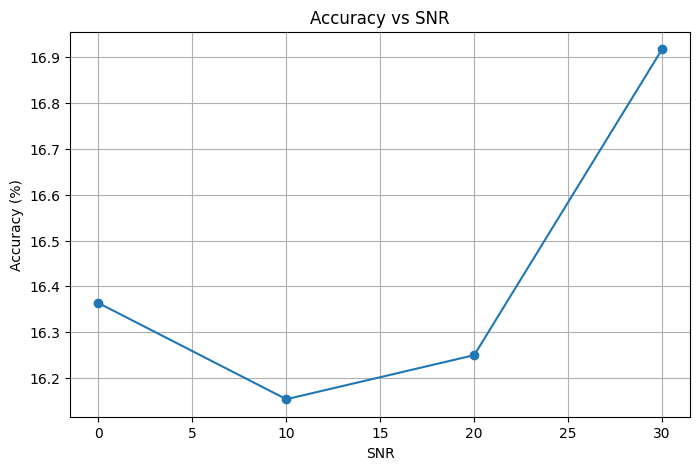

In [ ]:
trainer.train(train_dataloader, valid_dataloader)
trainer.plot_training_curves()
trainer.test(test_dataloader,LABEL_MAPPING)

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(2, 32, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.norm2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.norm3 = nn.BatchNorm1d(128)
        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.norm4 = nn.BatchNorm1d(256)

        self.pool = nn.MaxPool1d(kernel_size=4)
        self.dropout = nn.Dropout(0.5)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256 * 8, 6)

    def forward(self, x):
        x = torch.transpose(x, 1, 2)

        x = F.relu(self.norm1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.norm2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.norm3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.norm4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc(x)

        return F.log_softmax(x, dim=1)

In [ ]:
train_dataset = MyDataset(TRAIN_PATH)
valid_dataset = MyDataset(VALIDATION_PATH)
test_dataset = MyDataset(TEST_PATH)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = CNNModel().to(device)
config = Config(epochs=50, experiment_dir="cnn_model")
trainer = Trainer(model, config)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | Train Loss: 1.2083, Train Acc: 52.30% | Val Loss: 1.0522, Val Acc: 57.19% | Time: 3.4s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 2/50 | Train Loss: 1.0345, Train Acc: 58.98% | Val Loss: 0.9588, Val Acc: 60.65% | Time: 3.4s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 3/50 | Train Loss: 0.9731, Train Acc: 62.84% | Val Loss: 0.9276, Val Acc: 66.45% | Time: 3.3s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 4/50 | Train Loss: 0.9092, Train Acc: 68.81% | Val Loss: 0.8970, Val Acc: 66.94% | Time: 3.4s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 5/50 | Train Loss: 0.8527, Train Acc: 73.61% | Val Loss: 1.0639, Val Acc: 67.95% | Time: 3.4s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 6/50 | Train Loss: 0.7855, Train Acc: 79.50% | Val Loss: 0.8687, Val Acc: 76.42% | Time: 3.4s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 7/50 | Train Loss: 0.7450, Train Acc: 81.61% | Val Loss: 1.0612, Val Acc: 71.93% | Time: 3.4s 
----------------------------------------------------------------------------------------------------


Epoch 8/50 | Train Loss: 0.7214, Train Acc: 83.37% | Val Loss: 0.7996, Val Acc: 78.27% | Time: 3.4s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 9/50 | Train Loss: 0.7050, Train Acc: 83.92% | Val Loss: 0.7735, Val Acc: 82.43% | Time: 3.3s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 10/50 | Train Loss: 0.6959, Train Acc: 84.76% | Val Loss: 0.8207, Val Acc: 78.38% | Time: 3.4s 
----------------------------------------------------------------------------------------------------


Epoch 11/50 | Train Loss: 0.6861, Train Acc: 85.29% | Val Loss: 0.8525, Val Acc: 76.82% | Time: 3.3s 
----------------------------------------------------------------------------------------------------


Epoch 12/50 | Train Loss: 0.6801, Train Acc: 85.93% | Val Loss: 0.6669, Val Acc: 84.94% | Time: 3.4s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 13/50 | Train Loss: 0.6706, Train Acc: 86.48% | Val Loss: 0.7516, Val Acc: 83.43% | Time: 3.4s 
----------------------------------------------------------------------------------------------------


Epoch 14/50 | Train Loss: 0.6642, Train Acc: 86.83% | Val Loss: 0.6787, Val Acc: 84.57% | Time: 3.4s 
----------------------------------------------------------------------------------------------------


Epoch 15/50 | Train Loss: 0.6564, Train Acc: 87.41% | Val Loss: 0.6753, Val Acc: 84.61% | Time: 3.3s 
----------------------------------------------------------------------------------------------------


Epoch 16/50 | Train Loss: 0.6523, Train Acc: 88.06% | Val Loss: 0.8445, Val Acc: 83.76% | Time: 3.4s 
----------------------------------------------------------------------------------------------------


Epoch 17/50 | Train Loss: 0.6444, Train Acc: 88.68% | Val Loss: 0.7537, Val Acc: 83.83% | Time: 3.3s 
----------------------------------------------------------------------------------------------------


Epoch 18/50 | Train Loss: 0.6374, Train Acc: 89.20% | Val Loss: 0.6757, Val Acc: 85.81% | Time: 3.4s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 19/50 | Train Loss: 0.6120, Train Acc: 90.95% | Val Loss: 0.6832, Val Acc: 85.21% | Time: 3.3s 
----------------------------------------------------------------------------------------------------


Epoch 20/50 | Train Loss: 0.5975, Train Acc: 91.91% | Val Loss: 0.6733, Val Acc: 85.43% | Time: 3.3s 
----------------------------------------------------------------------------------------------------


Epoch 21/50 | Train Loss: 0.5917, Train Acc: 92.50% | Val Loss: 0.7203, Val Acc: 84.83% | Time: 3.3s 
----------------------------------------------------------------------------------------------------


Epoch 22/50 | Train Loss: 0.5806, Train Acc: 93.27% | Val Loss: 0.6995, Val Acc: 85.45% | Time: 3.4s 
----------------------------------------------------------------------------------------------------


Epoch 23/50 | Train Loss: 0.5739, Train Acc: 93.82% | Val Loss: 0.6912, Val Acc: 85.67% | Time: 3.4s 
----------------------------------------------------------------------------------------------------


Epoch 24/50 | Train Loss: 0.5663, Train Acc: 94.30% | Val Loss: 0.7318, Val Acc: 84.28% | Time: 3.5s 
----------------------------------------------------------------------------------------------------


Epoch 25/50 | Train Loss: 0.5470, Train Acc: 95.61% | Val Loss: 0.8070, Val Acc: 84.72% | Time: 3.4s 
----------------------------------------------------------------------------------------------------


Epoch 26/50 | Train Loss: 0.5402, Train Acc: 96.03% | Val Loss: 0.7471, Val Acc: 85.32% | Time: 3.4s 
----------------------------------------------------------------------------------------------------


Epoch 27/50 | Train Loss: 0.5342, Train Acc: 96.47% | Val Loss: 0.7261, Val Acc: 85.51% | Time: 3.4s 
----------------------------------------------------------------------------------------------------


Epoch 28/50 | Train Loss: 0.5303, Train Acc: 96.63% | Val Loss: 0.7474, Val Acc: 85.44% | Time: 3.5s 
----------------------------------------------------------------------------------------------------


Epoch 29/50 | Train Loss: 0.5264, Train Acc: 96.95% | Val Loss: 0.7506, Val Acc: 85.41% | Time: 3.4s 
----------------------------------------------------------------------------------------------------


Epoch 30/50 | Train Loss: 0.5246, Train Acc: 97.09% | Val Loss: 0.7253, Val Acc: 85.82% | Time: 3.4s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 31/50 | Train Loss: 0.5141, Train Acc: 97.63% | Val Loss: 0.7289, Val Acc: 85.69% | Time: 3.4s 
----------------------------------------------------------------------------------------------------


Epoch 32/50 | Train Loss: 0.5119, Train Acc: 97.76% | Val Loss: 0.7711, Val Acc: 85.41% | Time: 3.4s 
----------------------------------------------------------------------------------------------------


Epoch 33/50 | Train Loss: 0.5095, Train Acc: 97.99% | Val Loss: 0.7406, Val Acc: 85.76% | Time: 3.3s 
----------------------------------------------------------------------------------------------------


Epoch 34/50 | Train Loss: 0.5080, Train Acc: 97.96% | Val Loss: 0.7372, Val Acc: 85.61% | Time: 3.3s 
----------------------------------------------------------------------------------------------------


Epoch 35/50 | Train Loss: 0.5071, Train Acc: 98.16% | Val Loss: 0.7384, Val Acc: 85.81% | Time: 3.3s 
----------------------------------------------------------------------------------------------------


Epoch 36/50 | Train Loss: 0.5054, Train Acc: 98.20% | Val Loss: 0.7473, Val Acc: 85.71% | Time: 3.3s 
----------------------------------------------------------------------------------------------------


Epoch 37/50 | Train Loss: 0.5012, Train Acc: 98.51% | Val Loss: 0.7301, Val Acc: 85.80% | Time: 3.4s 
----------------------------------------------------------------------------------------------------


Epoch 38/50 | Train Loss: 0.4994, Train Acc: 98.65% | Val Loss: 0.7563, Val Acc: 85.07% | Time: 3.4s 
----------------------------------------------------------------------------------------------------


Epoch 39/50 | Train Loss: 0.5003, Train Acc: 98.50% | Val Loss: 0.7628, Val Acc: 85.59% | Time: 3.3s 
----------------------------------------------------------------------------------------------------


Epoch 40/50 | Train Loss: 0.4985, Train Acc: 98.60% | Val Loss: 0.7392, Val Acc: 85.74% | Time: 3.4s 
----------------------------------------------------------------------------------------------------


Epoch 41/50 | Train Loss: 0.4974, Train Acc: 98.71% | Val Loss: 0.7376, Val Acc: 85.66% | Time: 3.4s 
----------------------------------------------------------------------------------------------------


Epoch 42/50 | Train Loss: 0.4973, Train Acc: 98.67% | Val Loss: 0.7412, Val Acc: 85.81% | Time: 3.4s 
----------------------------------------------------------------------------------------------------


Epoch 43/50 | Train Loss: 0.4947, Train Acc: 98.88% | Val Loss: 0.7451, Val Acc: 85.70% | Time: 3.4s 
----------------------------------------------------------------------------------------------------


Epoch 44/50 | Train Loss: 0.4953, Train Acc: 98.83% | Val Loss: 0.7433, Val Acc: 85.80% | Time: 3.4s 
----------------------------------------------------------------------------------------------------


Epoch 45/50 | Train Loss: 0.4940, Train Acc: 98.95% | Val Loss: 0.7421, Val Acc: 85.86% | Time: 3.3s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 46/50 | Train Loss: 0.4940, Train Acc: 98.82% | Val Loss: 0.7476, Val Acc: 85.88% | Time: 3.4s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 47/50 | Train Loss: 0.4930, Train Acc: 98.97% | Val Loss: 0.7460, Val Acc: 85.82% | Time: 3.3s 
----------------------------------------------------------------------------------------------------


Epoch 48/50 | Train Loss: 0.4930, Train Acc: 98.94% | Val Loss: 0.7402, Val Acc: 85.79% | Time: 3.4s 
----------------------------------------------------------------------------------------------------


Epoch 49/50 | Train Loss: 0.4916, Train Acc: 99.08% | Val Loss: 0.7428, Val Acc: 85.89% | Time: 3.4s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 50/50 | Train Loss: 0.4917, Train Acc: 99.01% | Val Loss: 0.7448, Val Acc: 85.71% | Time: 3.3s 
----------------------------------------------------------------------------------------------------


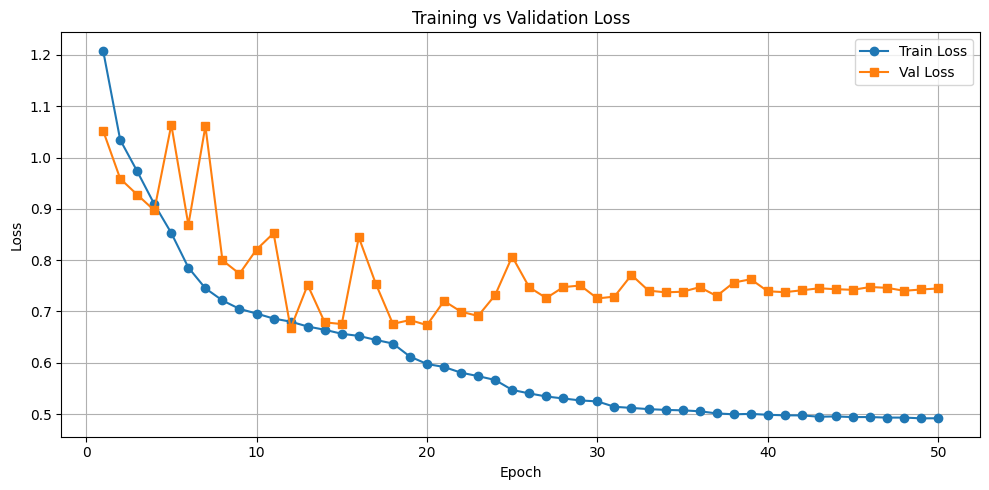

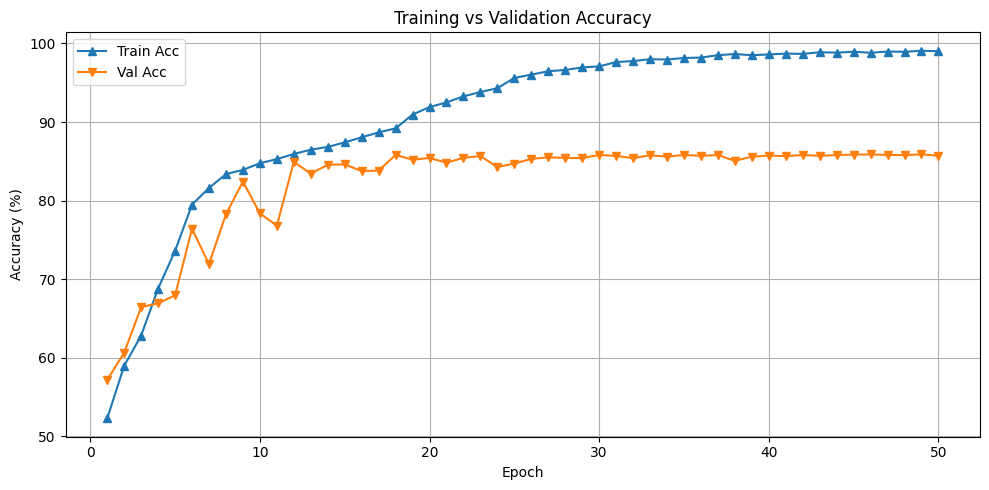

Test set: avg_loss: 0.7447, acc: 85.24%
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      1697
           1       0.86      0.85      0.85      1650
           2       0.85      0.83      0.84      1653
           3       0.83      0.86      0.84      1653
           4       0.83      0.85      0.84      1684
           5       0.86      0.82      0.84      1663

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



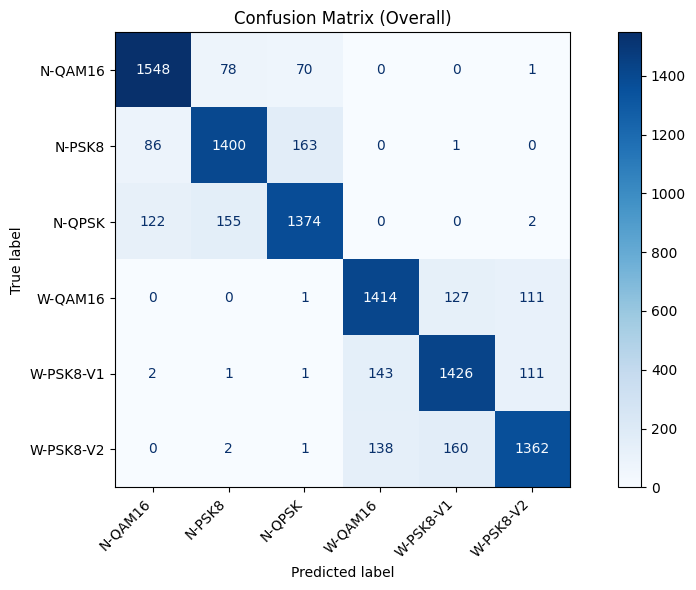

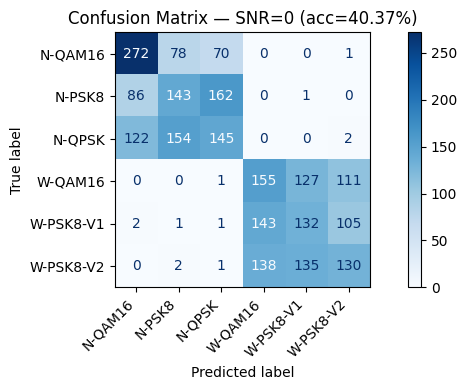

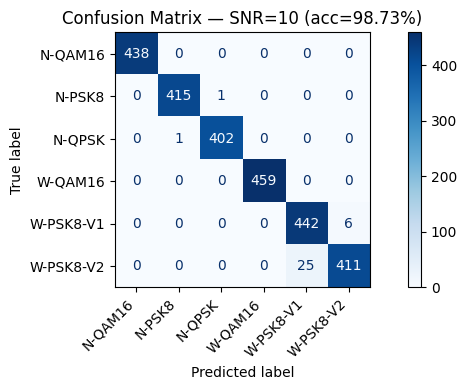

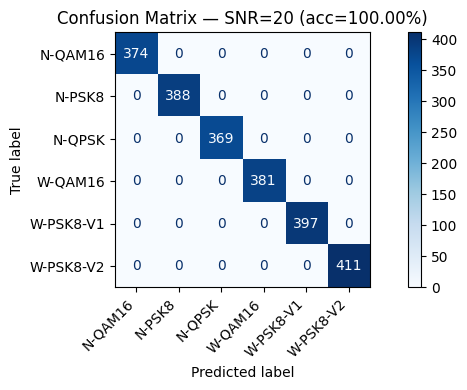

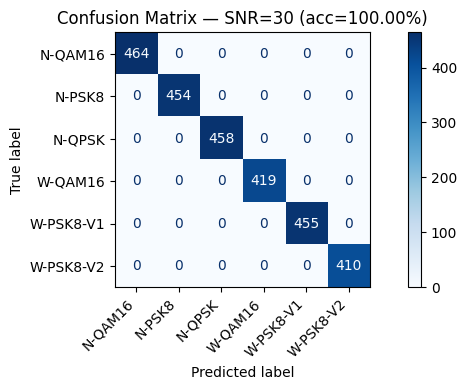

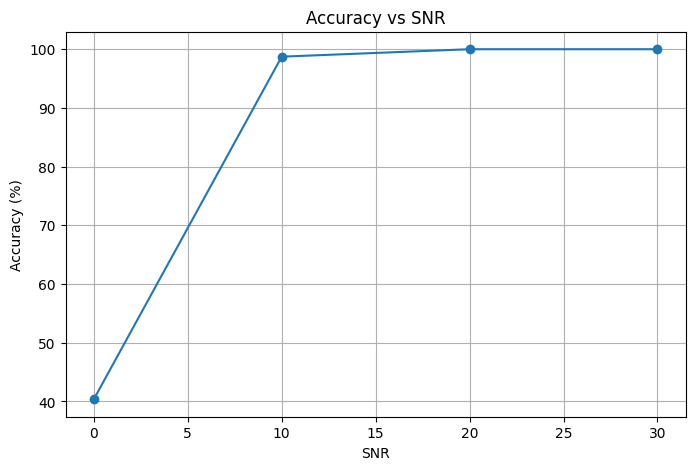

In [ ]:
trainer.train(train_dataloader, valid_dataloader)
trainer.plot_training_curves()
trainer.test(test_dataloader)

In [ ]:
# Augmentation functions
def horizontal_flip(signal):
    flipped = signal.copy()
    flipped[:, 0] = -flipped[:, 0]
    return flipped

def vertical_flip(signal):
    flipped = signal.copy()
    flipped[:, 1] = -flipped[:, 1]
    return flipped

def random_rotation(signal):
    possible_rotations = [0, np.pi / 2, np.pi, 3 * np.pi / 2]
    theta = random.choice(possible_rotations)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
    rotated = (rotation_matrix @ signal.T).T.astype(np.float32)
    return rotated

def add_gaussian_noise(signal, std=0.01):
    noisy = signal + np.random.normal(0, std, signal.shape).astype(np.float32)
    return noisy

def amplitude_scaling(signal, min_scale=0.8, max_scale=1.2):
    scale = np.random.uniform(min_scale, max_scale)
    scaled = signal * scale
    return scaled

def time_shift(signal, max_shift=5):
    shift = np.random.randint(-max_shift, max_shift + 1)
    shifted = np.roll(signal, shift, axis=0)
    return shifted

class DatasetWithAugmentation(torch.utils.data.Dataset):
    def __init__(self, path_to_data,
                 p_flip=0.5,
                 p_rotate=0.5,
                 p_noise=0.5,
                 p_scale=0.5,
                 p_shift=0.5):
        with h5py.File(path_to_data, 'r') as data:
            self.signals = np.array(data['signaux'], dtype=np.float32)
            self.snr = np.array(data['snr'], dtype=np.float32)
            self.labels_id = np.array(data['labels'], dtype=np.int64)

        self.p_flip = p_flip
        self.p_rotate = p_rotate
        self.p_noise = p_noise
        self.p_scale = p_scale
        self.p_shift = p_shift

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        signal = self.signals[idx].copy()
        snr = self.snr[idx]
        label = self.labels_id[idx]

        if random.random() < self.p_flip:
            signal = horizontal_flip(signal)

        if random.random() < self.p_flip:
            signal = vertical_flip(signal)

        if random.random() < self.p_rotate:
            signal = random_rotation(signal)

        if random.random() < self.p_noise:
            signal = add_gaussian_noise(signal)

        if random.random() < self.p_scale:
            signal = amplitude_scaling(signal)

        if random.random() < self.p_shift:
            signal = time_shift(signal)

        return signal, snr, label


In [ ]:
train_dataset = DatasetWithAugmentation(TRAIN_PATH)
valid_dataset = MyDataset(VALIDATION_PATH)
test_dataset = MyDataset(TEST_PATH)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = CNNModel().to(device)
config = Config(epochs=50, experiment_dir="cnn_model_with_augmentation")
trainer = Trainer(model, config)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | Train Loss: 1.2567, Train Acc: 51.40% | Val Loss: 1.0370, Val Acc: 57.02% | Time: 6.9s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 2/50 | Train Loss: 1.0439, Train Acc: 60.13% | Val Loss: 1.0451, Val Acc: 61.47% | Time: 6.8s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 3/50 | Train Loss: 0.9733, Train Acc: 64.78% | Val Loss: 1.5532, Val Acc: 48.58% | Time: 6.9s 
----------------------------------------------------------------------------------------------------


Epoch 4/50 | Train Loss: 0.9236, Train Acc: 68.28% | Val Loss: 0.9117, Val Acc: 70.84% | Time: 6.9s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 5/50 | Train Loss: 0.8906, Train Acc: 70.94% | Val Loss: 0.9611, Val Acc: 71.32% | Time: 7.0s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 6/50 | Train Loss: 0.8201, Train Acc: 77.42% | Val Loss: 1.2227, Val Acc: 64.36% | Time: 6.9s 
----------------------------------------------------------------------------------------------------


Epoch 7/50 | Train Loss: 0.7739, Train Acc: 80.34% | Val Loss: 0.7573, Val Acc: 80.27% | Time: 6.9s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 8/50 | Train Loss: 0.7446, Train Acc: 81.74% | Val Loss: 0.6991, Val Acc: 82.96% | Time: 6.8s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 9/50 | Train Loss: 0.7347, Train Acc: 82.22% | Val Loss: 0.7207, Val Acc: 82.62% | Time: 6.8s 
----------------------------------------------------------------------------------------------------


Epoch 10/50 | Train Loss: 0.7235, Train Acc: 82.95% | Val Loss: 0.8021, Val Acc: 79.72% | Time: 6.9s 
----------------------------------------------------------------------------------------------------


Epoch 11/50 | Train Loss: 0.7183, Train Acc: 83.03% | Val Loss: 0.7657, Val Acc: 80.57% | Time: 6.9s 
----------------------------------------------------------------------------------------------------


Epoch 12/50 | Train Loss: 0.7093, Train Acc: 83.72% | Val Loss: 0.8919, Val Acc: 75.48% | Time: 6.9s 
----------------------------------------------------------------------------------------------------


Epoch 13/50 | Train Loss: 0.7053, Train Acc: 83.71% | Val Loss: 0.8330, Val Acc: 78.43% | Time: 6.9s 
----------------------------------------------------------------------------------------------------


Epoch 14/50 | Train Loss: 0.7016, Train Acc: 83.90% | Val Loss: 0.6995, Val Acc: 83.59% | Time: 7.0s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 15/50 | Train Loss: 0.6890, Train Acc: 84.43% | Val Loss: 0.6712, Val Acc: 83.90% | Time: 6.9s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 16/50 | Train Loss: 0.6849, Train Acc: 84.54% | Val Loss: 0.7072, Val Acc: 82.46% | Time: 6.9s 
----------------------------------------------------------------------------------------------------


Epoch 17/50 | Train Loss: 0.6819, Train Acc: 85.13% | Val Loss: 0.6692, Val Acc: 84.76% | Time: 6.8s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 18/50 | Train Loss: 0.6792, Train Acc: 84.91% | Val Loss: 0.6622, Val Acc: 84.61% | Time: 6.8s 
----------------------------------------------------------------------------------------------------


Epoch 19/50 | Train Loss: 0.6781, Train Acc: 85.14% | Val Loss: 0.6602, Val Acc: 85.16% | Time: 6.8s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 20/50 | Train Loss: 0.6766, Train Acc: 85.15% | Val Loss: 0.6701, Val Acc: 84.77% | Time: 6.8s 
----------------------------------------------------------------------------------------------------


Epoch 21/50 | Train Loss: 0.6754, Train Acc: 85.35% | Val Loss: 0.6518, Val Acc: 85.55% | Time: 6.9s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 22/50 | Train Loss: 0.6734, Train Acc: 85.32% | Val Loss: 0.6676, Val Acc: 84.80% | Time: 6.9s 
----------------------------------------------------------------------------------------------------


Epoch 23/50 | Train Loss: 0.6734, Train Acc: 85.40% | Val Loss: 0.6610, Val Acc: 84.62% | Time: 6.9s 
----------------------------------------------------------------------------------------------------


Epoch 24/50 | Train Loss: 0.6718, Train Acc: 85.34% | Val Loss: 0.6535, Val Acc: 84.78% | Time: 6.9s 
----------------------------------------------------------------------------------------------------


Epoch 25/50 | Train Loss: 0.6703, Train Acc: 85.53% | Val Loss: 0.6415, Val Acc: 86.12% | Time: 6.8s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 26/50 | Train Loss: 0.6694, Train Acc: 85.49% | Val Loss: 0.6419, Val Acc: 85.99% | Time: 6.9s 
----------------------------------------------------------------------------------------------------


Epoch 27/50 | Train Loss: 0.6704, Train Acc: 85.59% | Val Loss: 0.6834, Val Acc: 85.19% | Time: 6.8s 
----------------------------------------------------------------------------------------------------


Epoch 28/50 | Train Loss: 0.6663, Train Acc: 85.87% | Val Loss: 0.6413, Val Acc: 85.89% | Time: 6.9s 
----------------------------------------------------------------------------------------------------


Epoch 29/50 | Train Loss: 0.6666, Train Acc: 85.68% | Val Loss: 0.6512, Val Acc: 85.38% | Time: 6.9s 
----------------------------------------------------------------------------------------------------


Epoch 30/50 | Train Loss: 0.6651, Train Acc: 85.91% | Val Loss: 0.6685, Val Acc: 84.79% | Time: 7.1s 
----------------------------------------------------------------------------------------------------


Epoch 31/50 | Train Loss: 0.6643, Train Acc: 85.83% | Val Loss: 0.6411, Val Acc: 86.04% | Time: 7.0s 
----------------------------------------------------------------------------------------------------


Epoch 32/50 | Train Loss: 0.6649, Train Acc: 85.79% | Val Loss: 0.6527, Val Acc: 85.03% | Time: 7.0s 
----------------------------------------------------------------------------------------------------


Epoch 33/50 | Train Loss: 0.6624, Train Acc: 86.08% | Val Loss: 0.6390, Val Acc: 86.11% | Time: 7.0s 
----------------------------------------------------------------------------------------------------


Epoch 34/50 | Train Loss: 0.6625, Train Acc: 85.97% | Val Loss: 0.6643, Val Acc: 85.27% | Time: 6.7s 
----------------------------------------------------------------------------------------------------


Epoch 35/50 | Train Loss: 0.6607, Train Acc: 86.00% | Val Loss: 0.6462, Val Acc: 85.99% | Time: 6.7s 
----------------------------------------------------------------------------------------------------


Epoch 36/50 | Train Loss: 0.6597, Train Acc: 86.21% | Val Loss: 0.6454, Val Acc: 85.89% | Time: 6.7s 
----------------------------------------------------------------------------------------------------


Epoch 37/50 | Train Loss: 0.6600, Train Acc: 86.06% | Val Loss: 0.6497, Val Acc: 85.40% | Time: 6.7s 
----------------------------------------------------------------------------------------------------


Epoch 38/50 | Train Loss: 0.6605, Train Acc: 86.13% | Val Loss: 0.6411, Val Acc: 86.39% | Time: 6.9s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 39/50 | Train Loss: 0.6593, Train Acc: 86.20% | Val Loss: 0.6515, Val Acc: 85.51% | Time: 6.7s 
----------------------------------------------------------------------------------------------------


Epoch 40/50 | Train Loss: 0.6536, Train Acc: 86.67% | Val Loss: 0.6474, Val Acc: 86.13% | Time: 6.7s 
----------------------------------------------------------------------------------------------------


Epoch 41/50 | Train Loss: 0.6516, Train Acc: 86.81% | Val Loss: 0.6354, Val Acc: 86.18% | Time: 6.7s 
----------------------------------------------------------------------------------------------------


Epoch 42/50 | Train Loss: 0.6543, Train Acc: 86.71% | Val Loss: 0.6339, Val Acc: 86.60% | Time: 6.6s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 43/50 | Train Loss: 0.6533, Train Acc: 86.51% | Val Loss: 0.6709, Val Acc: 84.48% | Time: 6.8s 
----------------------------------------------------------------------------------------------------


Epoch 44/50 | Train Loss: 0.6521, Train Acc: 86.50% | Val Loss: 0.6486, Val Acc: 85.41% | Time: 6.8s 
----------------------------------------------------------------------------------------------------


Epoch 45/50 | Train Loss: 0.6512, Train Acc: 86.98% | Val Loss: 0.6409, Val Acc: 86.01% | Time: 7.0s 
----------------------------------------------------------------------------------------------------


Epoch 46/50 | Train Loss: 0.6499, Train Acc: 86.93% | Val Loss: 0.6407, Val Acc: 86.33% | Time: 7.1s 
----------------------------------------------------------------------------------------------------


Epoch 47/50 | Train Loss: 0.6491, Train Acc: 87.16% | Val Loss: 0.6335, Val Acc: 86.30% | Time: 7.0s 
----------------------------------------------------------------------------------------------------


Epoch 48/50 | Train Loss: 0.6495, Train Acc: 86.98% | Val Loss: 0.6535, Val Acc: 85.55% | Time: 6.8s 
----------------------------------------------------------------------------------------------------


Epoch 49/50 | Train Loss: 0.6483, Train Acc: 87.03% | Val Loss: 0.6339, Val Acc: 86.32% | Time: 7.3s 
----------------------------------------------------------------------------------------------------


Epoch 50/50 | Train Loss: 0.6479, Train Acc: 87.16% | Val Loss: 0.6421, Val Acc: 85.80% | Time: 7.1s 
----------------------------------------------------------------------------------------------------


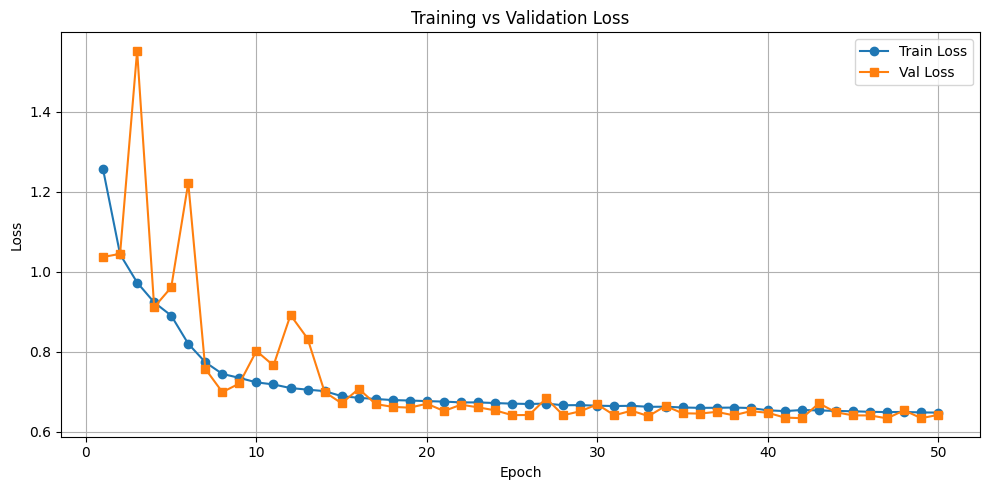

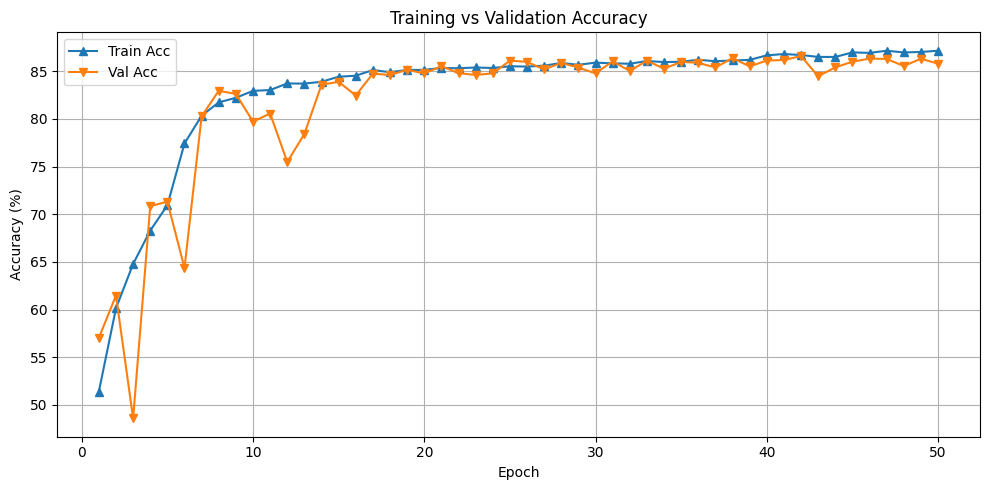

Test set: avg_loss: 0.6314, acc: 86.76%
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1697
           1       0.81      0.92      0.86      1650
           2       0.94      0.78      0.85      1653
           3       0.89      0.86      0.87      1653
           4       0.81      0.87      0.84      1684
           5       0.87      0.84      0.86      1663

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



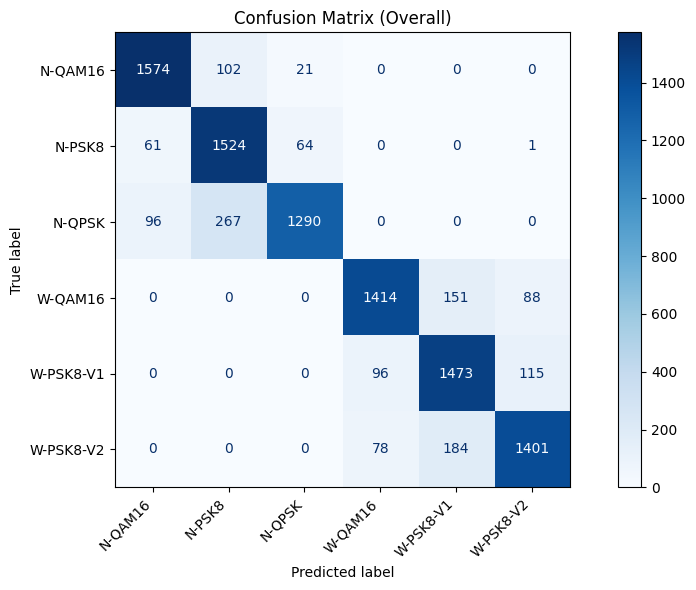

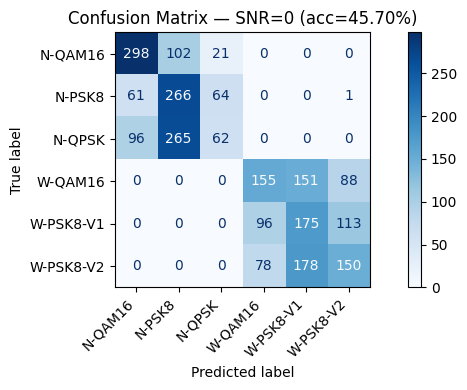

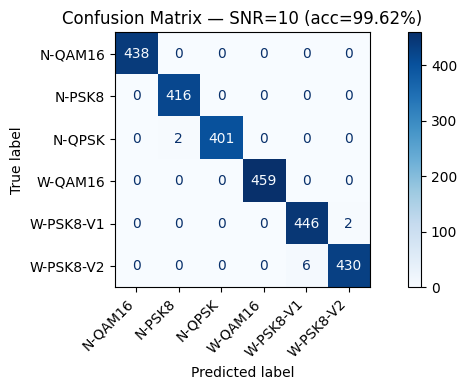

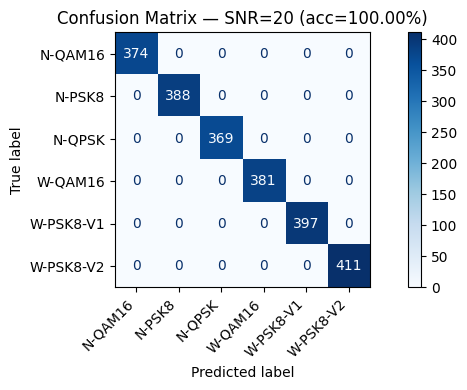

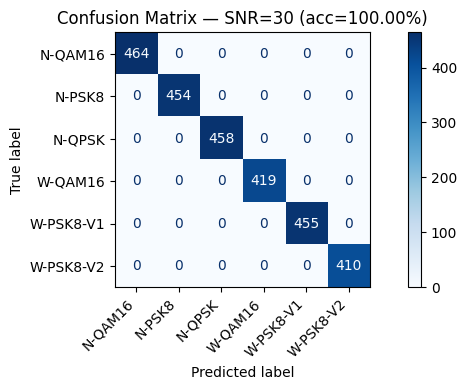

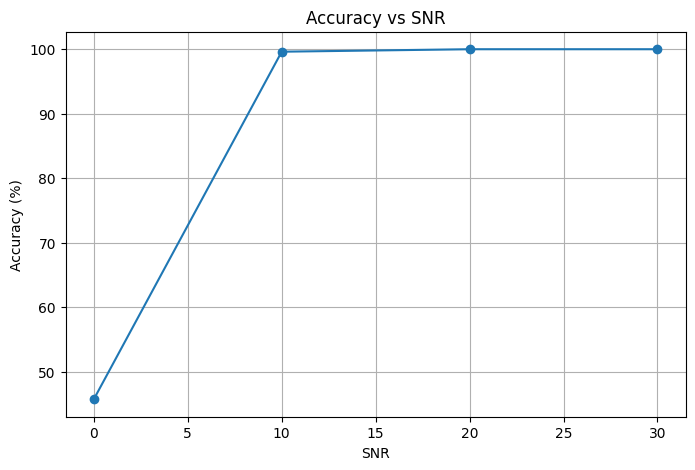

In [ ]:
trainer.train(train_dataloader, valid_dataloader)
trainer.plot_training_curves()
trainer.test(test_dataloader)

In [ ]:
# Residual Block
class BasicBlock1D(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(nn.Conv1d(in_channels, out_channels,kernel_size=1, stride=stride, bias=False),nn.BatchNorm1d(out_channels))

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += self.shortcut(identity)
        out = F.relu(out)

        return out


# ResNet-18 Backbone
class ResNet1D(nn.Module):
    def __init__(self, block, layers, num_classes=6):
        super().__init__()

        self.in_channels = 32
        self.conv1 = nn.Conv1d(2, 32, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(32)

        # Residual layers
        self.layer1 = self._make_layer(block, 32,  layers[0], stride=1)
        self.layer2 = self._make_layer(block, 64,  layers[1], stride=2)
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2)

        # Global average pooling + classifier
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []

        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels

        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        if x.shape[1] != 2:
            x = x.transpose(1, 2)

        out = F.relu(self.bn1(self.conv1(x)))

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.gap(out)
        out = out.squeeze(-1)

        out = self.fc(out)
        return F.log_softmax(out, dim=1)


# ResNet-18
def ResNet18_1D(num_classes=6):
    return ResNet1D(BasicBlock1D, [2, 2, 2, 2], num_classes)


In [ ]:
train_dataset = DatasetWithAugmentation(TRAIN_PATH)
valid_dataset = MyDataset(VALIDATION_PATH)
test_dataset = MyDataset(TEST_PATH)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = ResNet18_1D()
config = Config(epochs=75, experiment_dir="resnet_deeper_model_with_augmentation")
trainer = Trainer(model.to(device), config)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/75 | Train Loss: 1.1158, Train Acc: 53.94% | Val Loss: 0.9425, Val Acc: 60.50% | Time: 24.0s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 2/75 | Train Loss: 0.9081, Train Acc: 69.14% | Val Loss: 0.8065, Val Acc: 75.53% | Time: 24.5s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 3/75 | Train Loss: 0.7732, Train Acc: 79.54% | Val Loss: 0.7178, Val Acc: 83.32% | Time: 23.9s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 4/75 | Train Loss: 0.7164, Train Acc: 82.83% | Val Loss: 0.6858, Val Acc: 83.86% | Time: 23.7s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 5/75 | Train Loss: 0.6972, Train Acc: 83.55% | Val Loss: 0.7020, Val Acc: 84.39% | Time: 23.5s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 6/75 | Train Loss: 0.6888, Train Acc: 83.84% | Val Loss: 0.7854, Val Acc: 78.44% | Time: 23.5s 
----------------------------------------------------------------------------------------------------


Epoch 7/75 | Train Loss: 0.6787, Train Acc: 84.38% | Val Loss: 0.6686, Val Acc: 84.91% | Time: 24.2s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 8/75 | Train Loss: 0.6709, Train Acc: 84.80% | Val Loss: 0.6737, Val Acc: 84.52% | Time: 23.7s 
----------------------------------------------------------------------------------------------------


Epoch 9/75 | Train Loss: 0.6647, Train Acc: 85.05% | Val Loss: 0.7970, Val Acc: 83.11% | Time: 23.6s 
----------------------------------------------------------------------------------------------------


Epoch 10/75 | Train Loss: 0.6600, Train Acc: 84.94% | Val Loss: 0.6467, Val Acc: 86.18% | Time: 23.4s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 11/75 | Train Loss: 0.6552, Train Acc: 85.26% | Val Loss: 0.6410, Val Acc: 86.26% | Time: 23.4s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 12/75 | Train Loss: 0.6519, Train Acc: 85.35% | Val Loss: 0.6595, Val Acc: 85.07% | Time: 23.5s 
----------------------------------------------------------------------------------------------------


Epoch 13/75 | Train Loss: 0.6498, Train Acc: 85.49% | Val Loss: 0.6438, Val Acc: 85.22% | Time: 23.4s 
----------------------------------------------------------------------------------------------------


Epoch 14/75 | Train Loss: 0.6475, Train Acc: 85.71% | Val Loss: 0.7259, Val Acc: 83.43% | Time: 23.5s 
----------------------------------------------------------------------------------------------------


Epoch 15/75 | Train Loss: 0.6472, Train Acc: 85.46% | Val Loss: 0.6298, Val Acc: 86.23% | Time: 23.6s 
----------------------------------------------------------------------------------------------------


Epoch 16/75 | Train Loss: 0.6457, Train Acc: 85.69% | Val Loss: 0.6453, Val Acc: 85.49% | Time: 23.4s 
----------------------------------------------------------------------------------------------------


Epoch 17/75 | Train Loss: 0.6443, Train Acc: 85.56% | Val Loss: 0.7346, Val Acc: 83.71% | Time: 23.3s 
----------------------------------------------------------------------------------------------------


Epoch 18/75 | Train Loss: 0.6418, Train Acc: 85.83% | Val Loss: 0.6327, Val Acc: 86.16% | Time: 23.3s 
----------------------------------------------------------------------------------------------------


Epoch 19/75 | Train Loss: 0.6411, Train Acc: 85.88% | Val Loss: 0.6709, Val Acc: 84.96% | Time: 23.4s 
----------------------------------------------------------------------------------------------------


Epoch 20/75 | Train Loss: 0.6396, Train Acc: 85.91% | Val Loss: 0.6827, Val Acc: 84.21% | Time: 24.0s 
----------------------------------------------------------------------------------------------------


Epoch 21/75 | Train Loss: 0.6391, Train Acc: 86.08% | Val Loss: 0.6399, Val Acc: 85.81% | Time: 23.4s 
----------------------------------------------------------------------------------------------------


Epoch 22/75 | Train Loss: 0.6326, Train Acc: 86.56% | Val Loss: 0.6326, Val Acc: 85.83% | Time: 23.4s 
----------------------------------------------------------------------------------------------------


Epoch 23/75 | Train Loss: 0.6311, Train Acc: 86.54% | Val Loss: 0.6446, Val Acc: 86.05% | Time: 23.6s 
----------------------------------------------------------------------------------------------------


Epoch 24/75 | Train Loss: 0.6300, Train Acc: 86.63% | Val Loss: 0.6223, Val Acc: 86.59% | Time: 23.6s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 25/75 | Train Loss: 0.6304, Train Acc: 86.65% | Val Loss: 0.6238, Val Acc: 86.37% | Time: 23.5s 
----------------------------------------------------------------------------------------------------


Epoch 26/75 | Train Loss: 0.6291, Train Acc: 86.74% | Val Loss: 0.7132, Val Acc: 84.35% | Time: 23.5s 
----------------------------------------------------------------------------------------------------


Epoch 27/75 | Train Loss: 0.6291, Train Acc: 86.78% | Val Loss: 0.6191, Val Acc: 87.29% | Time: 23.4s (best model saved)
----------------------------------------------------------------------------------------------------


Epoch 28/75 | Train Loss: 0.6274, Train Acc: 86.85% | Val Loss: 0.6289, Val Acc: 86.68% | Time: 23.5s 
----------------------------------------------------------------------------------------------------


Epoch 29/75 | Train Loss: 0.6274, Train Acc: 86.88% | Val Loss: 0.6202, Val Acc: 87.29% | Time: 23.4s 
----------------------------------------------------------------------------------------------------


Epoch 30/75 | Train Loss: 0.6271, Train Acc: 87.09% | Val Loss: 0.6209, Val Acc: 87.10% | Time: 23.4s 
----------------------------------------------------------------------------------------------------


Epoch 31/75 | Train Loss: 0.6263, Train Acc: 86.94% | Val Loss: 0.6206, Val Acc: 87.01% | Time: 23.4s 
----------------------------------------------------------------------------------------------------


Epoch 32/75 | Train Loss: 0.6252, Train Acc: 87.10% | Val Loss: 0.6189, Val Acc: 86.99% | Time: 23.7s 
----------------------------------------------------------------------------------------------------


Epoch 33/75 | Train Loss: 0.6245, Train Acc: 87.26% | Val Loss: 0.6190, Val Acc: 87.14% | Time: 23.8s 
----------------------------------------------------------------------------------------------------


Epoch 34/75 | Train Loss: 0.6239, Train Acc: 87.47% | Val Loss: 0.6308, Val Acc: 86.30% | Time: 23.3s 
----------------------------------------------------------------------------------------------------


Epoch 35/75 | Train Loss: 0.6236, Train Acc: 87.38% | Val Loss: 0.6563, Val Acc: 85.62% | Time: 23.4s 
----------------------------------------------------------------------------------------------------


Epoch 36/75 | Train Loss: 0.6206, Train Acc: 87.51% | Val Loss: 0.6341, Val Acc: 86.17% | Time: 23.3s 
----------------------------------------------------------------------------------------------------


Epoch 37/75 | Train Loss: 0.6215, Train Acc: 87.71% | Val Loss: 0.6189, Val Acc: 87.07% | Time: 23.1s 
----------------------------------------------------------------------------------------------------


Epoch 38/75 | Train Loss: 0.6215, Train Acc: 87.78% | Val Loss: 0.6721, Val Acc: 85.33% | Time: 23.2s 
----------------------------------------------------------------------------------------------------


Epoch 39/75 | Train Loss: 0.6152, Train Acc: 88.26% | Val Loss: 0.6197, Val Acc: 87.10% | Time: 23.1s 
----------------------------------------------------------------------------------------------------


Epoch 40/75 | Train Loss: 0.6120, Train Acc: 88.48% | Val Loss: 0.6284, Val Acc: 87.07% | Time: 23.2s 
----------------------------------------------------------------------------------------------------


Epoch 41/75 | Train Loss: 0.6117, Train Acc: 88.43% | Val Loss: 0.6371, Val Acc: 86.74% | Time: 23.1s 
----------------------------------------------------------------------------------------------------


Epoch 42/75 | Train Loss: 0.6104, Train Acc: 88.73% | Val Loss: 0.6492, Val Acc: 86.13% | Time: 23.3s 
----------------------------------------------------------------------------------------------------


Epoch 43/75 | Train Loss: 0.6092, Train Acc: 88.76% | Val Loss: 0.6514, Val Acc: 85.76% | Time: 23.2s 
----------------------------------------------------------------------------------------------------


Epoch 44/75 | Train Loss: 0.6068, Train Acc: 89.16% | Val Loss: 0.6308, Val Acc: 86.94% | Time: 23.2s 
----------------------------------------------------------------------------------------------------


Epoch 45/75 | Train Loss: 0.6044, Train Acc: 89.36% | Val Loss: 0.6255, Val Acc: 87.10% | Time: 23.6s 
----------------------------------------------------------------------------------------------------


Epoch 46/75 | Train Loss: 0.6029, Train Acc: 89.42% | Val Loss: 0.6276, Val Acc: 87.24% | Time: 23.4s 
----------------------------------------------------------------------------------------------------


Epoch 47/75 | Train Loss: 0.6038, Train Acc: 89.53% | Val Loss: 0.6251, Val Acc: 87.03% | Time: 23.2s 
----------------------------------------------------------------------------------------------------


Epoch 48/75 | Train Loss: 0.6007, Train Acc: 89.63% | Val Loss: 0.6359, Val Acc: 86.91% | Time: 23.2s 
----------------------------------------------------------------------------------------------------


Epoch 49/75 | Train Loss: 0.5999, Train Acc: 89.79% | Val Loss: 0.6314, Val Acc: 87.10% | Time: 23.0s 
----------------------------------------------------------------------------------------------------


Epoch 50/75 | Train Loss: 0.5981, Train Acc: 89.80% | Val Loss: 0.6333, Val Acc: 86.49% | Time: 23.2s 
----------------------------------------------------------------------------------------------------


Epoch 51/75 | Train Loss: 0.5960, Train Acc: 90.14% | Val Loss: 0.6289, Val Acc: 87.24% | Time: 23.2s 
----------------------------------------------------------------------------------------------------


Epoch 52/75 | Train Loss: 0.5956, Train Acc: 90.12% | Val Loss: 0.6432, Val Acc: 86.76% | Time: 23.1s 
----------------------------------------------------------------------------------------------------


Epoch 53/75 | Train Loss: 0.5950, Train Acc: 90.23% | Val Loss: 0.6323, Val Acc: 86.77% | Time: 23.1s 
----------------------------------------------------------------------------------------------------


Epoch 54/75 | Train Loss: 0.5932, Train Acc: 90.43% | Val Loss: 0.6338, Val Acc: 86.98% | Time: 23.3s 
----------------------------------------------------------------------------------------------------


Epoch 55/75 | Train Loss: 0.5932, Train Acc: 90.23% | Val Loss: 0.6317, Val Acc: 86.92% | Time: 23.5s 
----------------------------------------------------------------------------------------------------


Epoch 56/75 | Train Loss: 0.5931, Train Acc: 90.19% | Val Loss: 0.6353, Val Acc: 86.96% | Time: 23.4s 
----------------------------------------------------------------------------------------------------


Epoch 57/75 | Train Loss: 0.5907, Train Acc: 90.70% | Val Loss: 0.6332, Val Acc: 86.75% | Time: 23.5s 
----------------------------------------------------------------------------------------------------


Epoch 58/75 | Train Loss: 0.5908, Train Acc: 90.60% | Val Loss: 0.6348, Val Acc: 86.68% | Time: 23.9s 
----------------------------------------------------------------------------------------------------


Epoch 59/75 | Train Loss: 0.5905, Train Acc: 90.82% | Val Loss: 0.6350, Val Acc: 86.98% | Time: 23.5s 
----------------------------------------------------------------------------------------------------


Epoch 60/75 | Train Loss: 0.5874, Train Acc: 90.84% | Val Loss: 0.6346, Val Acc: 86.90% | Time: 23.2s 
----------------------------------------------------------------------------------------------------


Epoch 61/75 | Train Loss: 0.5884, Train Acc: 90.81% | Val Loss: 0.6350, Val Acc: 86.92% | Time: 23.2s 
----------------------------------------------------------------------------------------------------


Epoch 62/75 | Train Loss: 0.5890, Train Acc: 90.77% | Val Loss: 0.6359, Val Acc: 87.02% | Time: 23.1s 
----------------------------------------------------------------------------------------------------


Epoch 63/75 | Train Loss: 0.5873, Train Acc: 90.90% | Val Loss: 0.6350, Val Acc: 86.92% | Time: 23.2s 
----------------------------------------------------------------------------------------------------


Epoch 64/75 | Train Loss: 0.5890, Train Acc: 90.73% | Val Loss: 0.6359, Val Acc: 86.89% | Time: 23.3s 
----------------------------------------------------------------------------------------------------


Epoch 65/75 | Train Loss: 0.5885, Train Acc: 90.76% | Val Loss: 0.6345, Val Acc: 86.89% | Time: 23.2s 
----------------------------------------------------------------------------------------------------


Epoch 66/75 | Train Loss: 0.5881, Train Acc: 90.94% | Val Loss: 0.6363, Val Acc: 86.89% | Time: 23.2s 
----------------------------------------------------------------------------------------------------


Epoch 67/75 | Train Loss: 0.5869, Train Acc: 90.89% | Val Loss: 0.6346, Val Acc: 86.96% | Time: 23.2s 
----------------------------------------------------------------------------------------------------


Epoch 68/75 | Train Loss: 0.5875, Train Acc: 90.93% | Val Loss: 0.6365, Val Acc: 86.99% | Time: 23.3s 
----------------------------------------------------------------------------------------------------


Epoch 69/75 | Train Loss: 0.5872, Train Acc: 90.90% | Val Loss: 0.6354, Val Acc: 86.95% | Time: 23.3s 
----------------------------------------------------------------------------------------------------


Epoch 70/75 | Train Loss: 0.5872, Train Acc: 90.88% | Val Loss: 0.6380, Val Acc: 87.00% | Time: 23.1s 
----------------------------------------------------------------------------------------------------


Epoch 71/75 | Train Loss: 0.5857, Train Acc: 91.01% | Val Loss: 0.6379, Val Acc: 86.93% | Time: 23.8s 
----------------------------------------------------------------------------------------------------


Epoch 72/75 | Train Loss: 0.5868, Train Acc: 90.78% | Val Loss: 0.6366, Val Acc: 87.00% | Time: 23.3s 
----------------------------------------------------------------------------------------------------


Epoch 73/75 | Train Loss: 0.5850, Train Acc: 91.09% | Val Loss: 0.6380, Val Acc: 86.67% | Time: 23.1s 
----------------------------------------------------------------------------------------------------


Epoch 74/75 | Train Loss: 0.5851, Train Acc: 91.03% | Val Loss: 0.6381, Val Acc: 86.99% | Time: 23.1s 
----------------------------------------------------------------------------------------------------


Epoch 75/75 | Train Loss: 0.5859, Train Acc: 90.95% | Val Loss: 0.6359, Val Acc: 87.03% | Time: 23.2s 
----------------------------------------------------------------------------------------------------


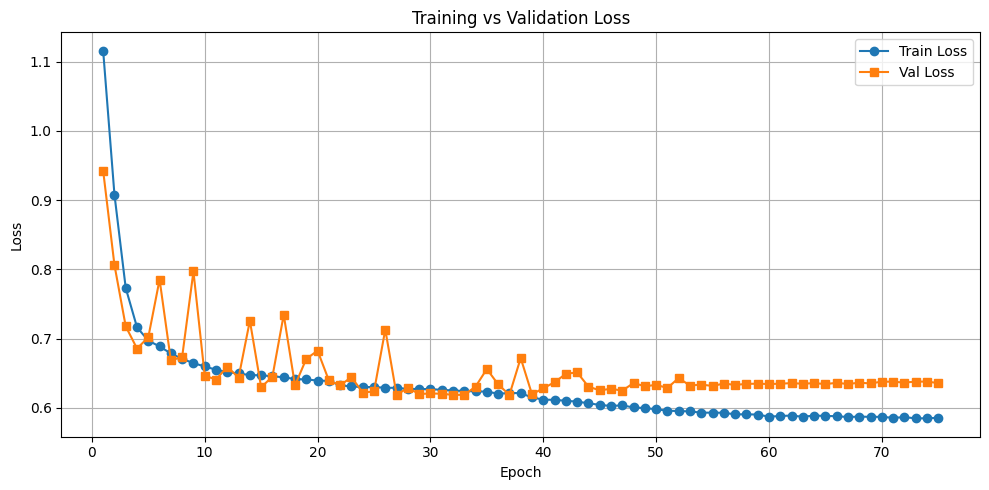

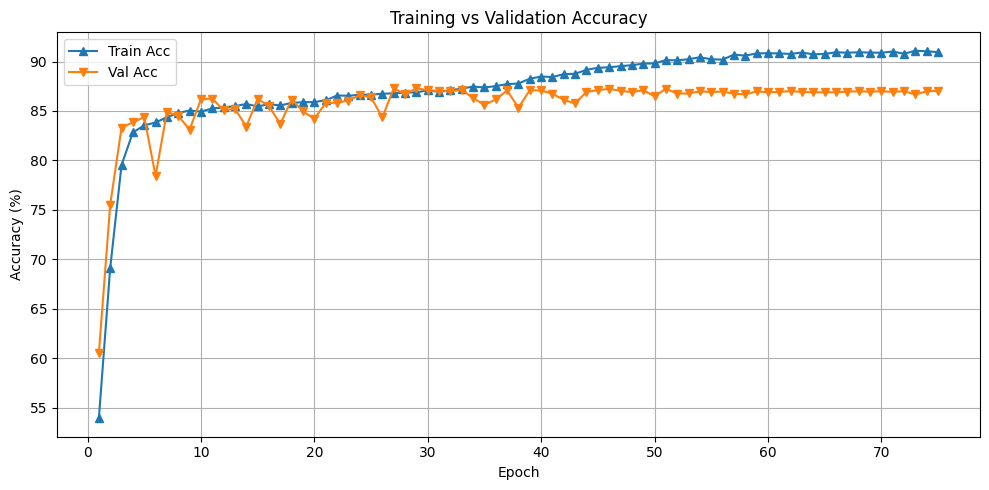

Test set: avg_loss: 0.6139, acc: 87.43%
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1697
           1       0.82      0.94      0.87      1650
           2       0.99      0.75      0.85      1653
           3       0.80      0.93      0.86      1653
           4       0.95      0.81      0.87      1684
           5       0.87      0.86      0.86      1663

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



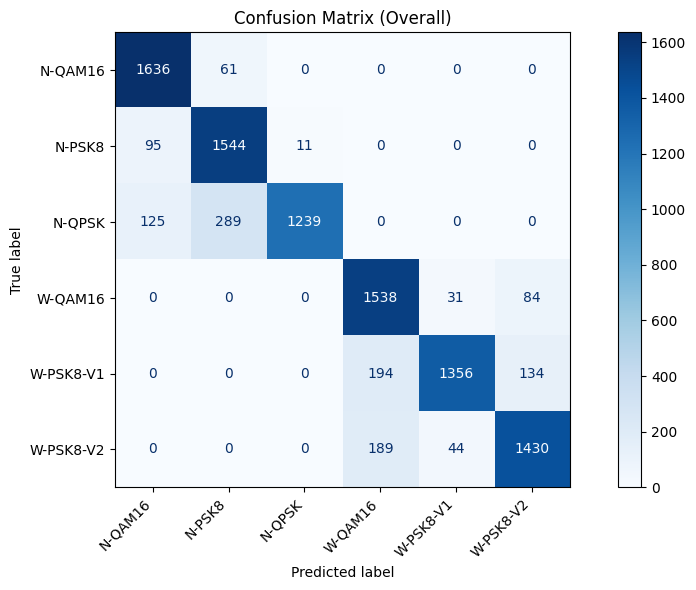

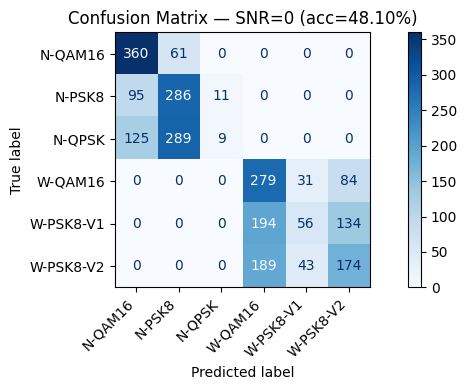

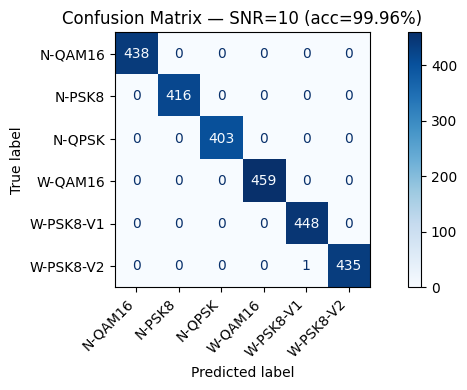

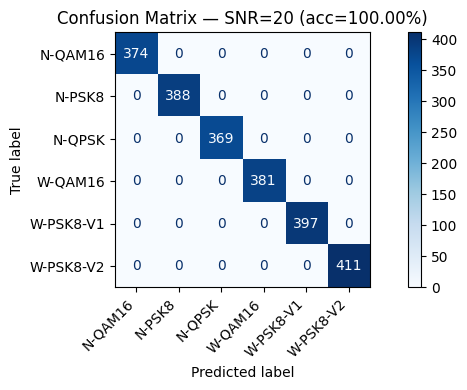

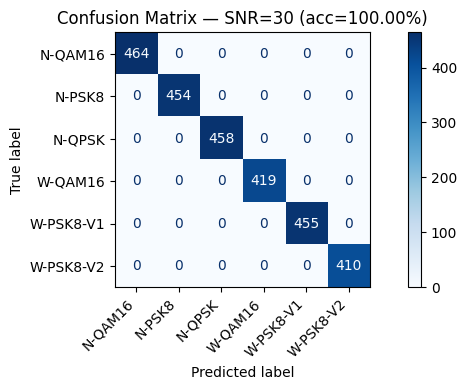

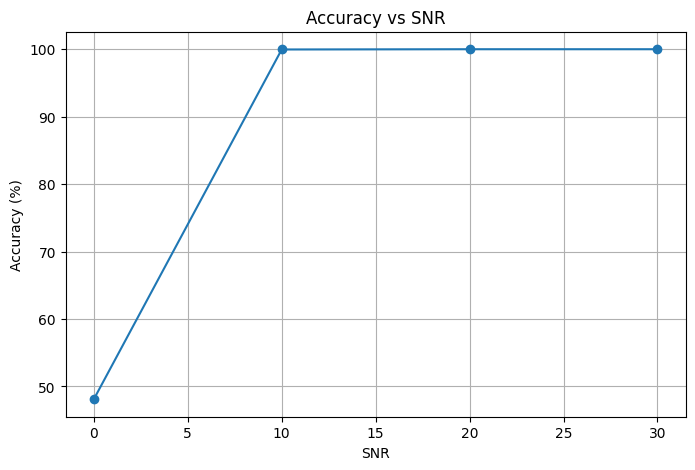

In [ ]:
trainer.train(train_dataloader, valid_dataloader)
trainer.plot_training_curves()
trainer.test(test_dataloader)

## Synthèse de résultats

Une fois que votre ou vos réseaux sont entrainez vous comparez leurs performances selon les métriques définies en introduction sur l'ensemble de test sans oublier de mesurer également la complexité de chaque approche en termes de nombre de paramètres. Si vous avez testé des approches qui vous semblent avoir échoué vous pouvez rédiger un petit paragraphe pour expliquer votre analyse de cet échec.

In [ ]:
count_n_param(CNNModel())

142950

In [ ]:
count_n_param(ResNet18_1D())

965254

**Approche 1 : CNN**

Il s'agit de notre approche baseline, avec un modèle assez léger de 142.000 paramètres (plus léger que le second) et entraîné sur les données non transformées. Avec cette approche, on obtient une accuracy de 85,3%.

Il semble que le CNN "simple" arrive plutôt bien à capturer les caractéristiques locales de nos signaux, notamment sur la classe 0 (f1-score de 0.9), lorsque les signaux sont suffisamment clairs et portent suffisamment d'information. On n'observe pas de sur-apprentissage important.

Comme les approches qui vont suivre, le modèle performe presque parfaitement lorsque le bruit est significativement moins fort que le signal (1000 à 10 fois moins puissant, accuracy > 98%), mais performe plus faiblement lorsque le bruit est aussi fort que le signal dans les données (0dB, accuracy = 40%). Néanmoins même sur ce niveau de bruit, la performance est bien supérieure à celle d'une classification aléatoire.

**Approche 2 : CNN avec augmentation des données**

On conserve la même architecture et 142.000 paramètres, mais on enrichit aléatoirement les données d'entraînement à l'aide de bruit, rotations de phases, ou flips des données. Le réseau est plus invariant aux perturbations, et cela améliore les performances par rapport à la première approche (86,8% d'accuracy).

C'est l'approche la plus efficace, avec un nombre de paramètres à apprendre qui reste modéré. La classe 0 reste la mieux prédite (f1-score 0.92) mais toutes les autres classes sauf la classe 4 voient leur f1-score augmenter. La classification est encore plus proche de la perfection pour les niveaux de SNR 10 à 30 dB (accuracy > 99,6%), et augmente légèrement pour le niveau de SNR 0 dB (gain de 5% d'accuracy).

La classe N-QPSK surtout et W-PSK8-V1 dans une moindre mesure sont difficiles à prédire pour le modèle. Le plafond du modèle correspond aux signaux à très faible SNR, où l'information est trop dégradée pour être récupérée par le modèle.

**Approche 3 : ResNet**

Ce modèle est beaucoup plus complexe et lourd (965.254 paramètres, environ 7x plus lourd que le précédent). Cette approche atteint la meilleure performance intrinsèque, avec 87.4% d'accuracy. La capacité d'extaction de caractéristiques est bien plus importante, et le modèle atteint une précision quasi parfaite sur certaines classes (notamment la classe 2). Cependant cela se traduit par un rappel assez faible sur cette classe (75%), ce qui n'est pas un comportement souhaité dans notre cas.

Le modèle est parfait lorsque le signal est plus puissant que le bruit (1 seule erreur pour SNR > 0 dB, accuracy > 99,9%), et la performance augmente légèrement sur le niveau de SNR 0dB (48% d'accuracy, gain de 3%). Cependant les résultats sur ce niveau de bruit sont fortement déséquilibrés et le modèle ne prédit quasiment plus les classes N-QPSK et W-PSK8-V1.

Le gain de performance est marginal par rapport à l'augmentation de la complexité de cette approche. Cependant le problème de classifciation à faible SNR est encore une fois limité par la quantité d'information présente dans le signal, et non par la capacité du réseau de neurones. Ajouter de la profondeur et des connexions résiduelles permet d'affiner la classification mais pas d'extraire ou créer l'information là ou le bruit détériore le signal.


**Conclusion :** Si l'on voulait encore gagner de la performance, il faudrait sûrement se concentrer sur les signaux à SNR=0dB, et ajouter un réseau en amont permettant de débruiter le signal avant de le passer au modèle de l'approche 2. On peut par exemple penser à des *denoising autoencoders*.